#Descarga de archivos y carga de librerías

In [1]:
# https://www.properati.com.ar/data
! wget -O ar_properties.csv.gz -q https://storage.googleapis.com/properati-data-public/ar_properties.csv.gz
! gzip -d -f /content/ar_properties.csv.gz

In [2]:
!gdown -q --fuzzy https://drive.google.com/file/d/1dQYr7i2DMiW3nKUe7ZOjspcDHSJeXU7-/view
!unzip -q /content/usdpersqm.zip 

In [3]:
!gdown -q --fuzzy https://drive.google.com/file/d/1kO11Na-ZKOg7y86wc2E6xWKvLFEk20M8/view
!unzip -q /content/a_predecir.zip 

In [4]:
import pandas as pd
import numpy as np
import scipy as sp
import math
import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [5]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Lectura de datos

##Carga

In [6]:
df_train = pd.read_csv('/content/ar_properties.csv', index_col="id", parse_dates = ['start_date','end_date','created_on','end_date'])  

In [7]:
df_pred = pd.read_csv('/content/a_predecir.csv', index_col="id", parse_dates = ['start_date','end_date','created_on'])

Archivo con precios por metro cuadrado extraído de los blogs de Properati. Algunos meses no estaban presentes y se llenaron mediante interpolación lineal con un script.

In [8]:
df_usdpersqm = pd.read_csv('/content/usdpersqm.csv', index_col=['Barrio','Año','Mes'])

##Un pequeño vistazo...

In [9]:
df_train.head()

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,...,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
id,,,,,,,,,,,,,,,,,,,,,
DyVXfkpKygVBKuUk5olH+A==,Propiedad,2020-08-22,2020-09-03,2020-08-22,-34.407468,-58.957367,Argentina,Bs.As. G.B.A. Zona Norte,Pilar,NaN,...,NaN,133139.0,NaN,NaN,NaN,Mensual,VENTA - Lote Industrial 130.000m2 - Parque Ind...,Lote (Nro.50) mide 133.139 m2\n<br>Valor: U$S ...,Lote,Venta
9naojilaMecJN4jlQiTkGg==,Propiedad,2020-08-22,2020-09-04,2020-08-22,-37.996039,-57.542509,Argentina,Buenos Aires Costa Atlántica,Mar del Plata,NaN,...,NaN,687.0,687.0,NaN,NaN,Mensual,Casa - Santa Cecilia,Conjunto edilicio de casa y departamentos en b...,Otro,Venta
tlCPRJPjoDEUzuuCelemAQ==,Propiedad,2020-08-22,2020-08-31,2020-08-22,-31.380187,-58.009182,Argentina,Entre Ríos,Concordia,NaN,...,1.0,80.0,80.0,NaN,NaN,Mensual,Casa - Concordia,"Casa de un dormitorio, cocina, baño, living co...",Casa,Alquiler
Zw3b91glQUO3HNrM5fPYlQ==,Propiedad,2020-08-22,2020-09-04,2020-08-22,-27.494106,-55.123455,Argentina,Misiones,Oberá,NaN,...,1.0,NaN,NaN,NaN,NaN,Mensual,Terreno - Obera,IMPORTANTE PROPIEDAD EN VENTA EN OBERA MISIONE...,Lote,Venta
bsU81gm9JEgtZCbTYgvykg==,Propiedad,2020-08-22,2020-09-04,2020-08-22,-32.948856,-60.630464,Argentina,Santa Fe,Rosario,NaN,...,1.0,76.0,66.0,NaN,NaN,Mensual,Departamento - Rosario,PORTAL DE LOS MARINOS<br>Es un complejo de viv...,Departamento,Venta


In [10]:
df_pred.head()

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,...,title,description,property_type,operation_type,details,additionals,services,l4,l5,l6
id,,,,,,,,,,,,,,,,,,,,,
1,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.407908,-34.601266,Argentina,Capital Federal,Balvanera,3.0,...,Jean Jaures 700 - Departamento en Venta en Bal...,"Descripción básica:<br>- ¡Gran oportunidad, de...",Departamento,Venta,"Superficie 48.6m2, Ambientes 3, Baños 1, Dormi...","Aceptan Mascotas, Terraza","Gas, Luz",NaN,NaN,NaN
2,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.487296,-34.570272,Argentina,Capital Federal,Villa Urquiza,3.0,...,Nahuel Huapi Al 4900 - Departamento en Venta e...,Edificio de Nivel Superior en la zona! - Detal...,Departamento,Venta,"Superficie 86m2, Ambientes 3, Baños 2, Cochera...","Pileta, Seguridad, SUM, Laundry, Balcón, Terraza","Gas, Luz",NaN,NaN,NaN
3,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.414550,-34.585000,Argentina,Capital Federal,Palermo,5.0,...,Arenales Al 3700 - Departamento en Venta en Pa...,Excelente piso con palier privado y entrada de...,Departamento,Venta,"Superficie 172m2, Ambientes 5, Baños 2, Cocher...","Aceptan Mascotas, Balcón","Gas, Luz",NaN,NaN,NaN
4,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.399793,-34.600414,Argentina,Capital Federal,Balvanera,2.0,...,Pasteur 800 - Departamento en Venta en Balvane...,¡Dos ambientes con dependencia en zona Faculta...,Departamento,Venta,"Superficie 61.05m2, Ambientes 2, Baños 1, Dorm...",NaN,"Gas, Luz",NaN,NaN,NaN
5,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.426532,-34.578066,Argentina,Capital Federal,Palermo,2.0,...,Medrano Al 1200 - Departamento en Venta en Pal...,"40% de Anticipo, Saldo en 28 Cuotas<br><br>Air...",Departamento,Venta,"Superficie 52m2, Ambientes 2, Baños 2, Dormito...","Pileta, SUM, Gimnasio, Aceptan Mascotas, Terraza",NaN,NaN,NaN,NaN


In [11]:
df_usdpersqm.head()

Precio m² (USD)
Barrio        Año  Mes                 
Puerto Madero 2020 5        6423.487964
                   6        6559.166353
                   7        6568.884547
                   8        6254.178423
                   9        5939.472299

# Análisis del conjunto de datos

##Estadísticas descriptivas

Algunos valores de end_date son anómalos (ver Describe) por eso no se convierte a fecha adecuadamente.

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, DyVXfkpKygVBKuUk5olH+A== to rEynGyGrrsxNeG0ib5vUBA==
Data columns (total 24 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   ad_type          1000000 non-null  object        
 1   start_date       1000000 non-null  datetime64[ns]
 2   end_date         1000000 non-null  object        
 3   created_on       1000000 non-null  datetime64[ns]
 4   lat              894233 non-null   float64       
 5   lon              894191 non-null   float64       
 6   l1               1000000 non-null  object        
 7   l2               1000000 non-null  object        
 8   l3               965273 non-null   object        
 9   l4               306162 non-null   object        
 10  l5               5530 non-null     object        
 11  l6               0 non-null        float64       
 12  rooms            714179 non-null   float64       
 13  bedrooms         64993

price_period, l4, l5 y l6 puede que sean irrelevantes para predecir (aunque convendría filtrar precios no mensuales de df dependiendo de qué signifique la columna). Details, additionals y services solo están en los datos a predecir, aunque algo de la información textual puede llegar a ser útil.

In [13]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1087 entries, 1 to 1087
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ad_type          1087 non-null   object        
 1   start_date       1087 non-null   datetime64[ns]
 2   end_date         1087 non-null   datetime64[ns]
 3   created_on       1087 non-null   datetime64[ns]
 4   lat              1087 non-null   float64       
 5   lon              1087 non-null   float64       
 6   l1               1087 non-null   object        
 7   l2               1087 non-null   object        
 8   l3               1087 non-null   object        
 9   rooms            1083 non-null   float64       
 10  bedrooms         958 non-null    float64       
 11  bathrooms        1083 non-null   float64       
 12  surface_total    1087 non-null   float64       
 13  surface_covered  1087 non-null   float64       
 14  price            0 non-null      float64

Los avisos cubren un año entero.

In [14]:
df_train.describe(datetime_is_numeric = True)

,start_date,created_on,lat,lon,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,1000000,1000000,894233.000000,894191.000000,0.0,714179.000000,649933.000000,765122.000000,477831.000000,4.877560e+05,9.582430e+05
mean,2020-11-29 05:41:56.025599744,2020-11-29 05:41:56.025599744,-34.377500,-59.491698,NaN,2.916567,2.097815,1.708581,513.760752,1.165622e+04,3.460940e+05
min,2020-05-24 00:00:00,2020-05-24 00:00:00,-54.841484,-122.538399,NaN,1.000000,-16.000000,1.000000,-136.000000,-1.300000e+02,0.000000e+00
25%,2020-08-28 00:00:00,2020-08-28 00:00:00,-34.723328,-58.876930,NaN,2.000000,1.000000,1.000000,50.000000,4.500000e+01,3.800000e+04
50%,2020-11-14 00:00:00,2020-11-14 00:00:00,-34.593014,-58.493790,NaN,3.000000,2.000000,1.000000,95.000000,7.800000e+01,9.700000e+04
75%,2021-03-11 00:00:00,2021-03-11 00:00:00,-34.415841,-58.397472,NaN,4.000000,3.000000,2.000000,250.000000,1.680000e+02,2.100000e+05
max,2021-06-17 00:00:00,2021-06-17 00:00:00,49.633731,180.000000,NaN,40.000000,900.000000,20.000000,200000.000000,2.147484e+09,3.100000e+09
std,NaN,NaN,3.035987,2.800543,NaN,1.739685,2.079008,1.092221,4297.241604,4.443191e+06,5.713690e+06


Todas las entradas a predecir son de abril de 2022. La utilidad de las fechas en df_train es más para arreglar precios que para alimentárselo al algoritmo.

In [15]:
df_pred.describe(datetime_is_numeric = True)

,start_date,end_date,created_on,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,price_period,l4,l5,l6
count,1087,1087,1087,1087.000000,1087.000000,1083.000000,958.000000,1083.000000,1087.000000,1087.000000,0.0,0.0,0.0,0.0,0.0
mean,2022-04-01 00:00:00,2022-04-01 00:00:00,2022-04-01 00:00:00,-58.224783,-34.464554,2.838412,2.070981,1.417359,89.930230,89.930230,NaN,NaN,NaN,NaN,NaN
min,2022-04-01 00:00:00,2022-04-01 00:00:00,2022-04-01 00:00:00,-65.217590,-38.015202,0.000000,0.000000,0.000000,16.620000,16.620000,NaN,NaN,NaN,NaN,NaN
25%,2022-04-01 00:00:00,2022-04-01 00:00:00,2022-04-01 00:00:00,-58.457974,-34.614796,2.000000,1.000000,1.000000,42.245000,42.245000,NaN,NaN,NaN,NaN,NaN
50%,2022-04-01 00:00:00,2022-04-01 00:00:00,2022-04-01 00:00:00,-58.433815,-34.595959,3.000000,2.000000,1.000000,66.000000,66.000000,NaN,NaN,NaN,NaN,NaN
75%,2022-04-01 00:00:00,2022-04-01 00:00:00,2022-04-01 00:00:00,-58.409390,-34.578911,4.000000,3.000000,2.000000,102.000000,102.000000,NaN,NaN,NaN,NaN,NaN
max,2022-04-01 00:00:00,2022-04-01 00:00:00,2022-04-01 00:00:00,58.594000,34.819000,13.000000,12.000000,7.000000,551.520000,551.520000,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,5.022201,2.987259,1.498219,1.226311,0.757802,76.687828,76.687828,NaN,NaN,NaN,NaN,NaN


Los tipos de aviso de la base de datos son todos de propiedad. El valor más común de end_date es "hasta el final de los tiempos".

In [16]:
df_train.describe(include = 'object')

,ad_type,end_date,l1,l2,l3,l4,l5,currency,price_period,title,description,property_type,operation_type
count,1000000,1000000,1000000,1000000,965273,306162,5530,955491,429870,999999,999958,1000000,1000000
unique,1,450,4,43,1367,1070,21,5,3,548833,817449,10,3
top,Propiedad,9999-12-31,Argentina,Capital Federal,Rosario,Nordelta,BarrioPortezuelo,USD,Mensual,casa-venta,Departamento en Alquiler de 1 dorm. en Cordoba,Departamento,Venta
freq,1000000,208960,983115,265125,61746,19479,735,738157,429842,3338,1980,457907,750831


Los datos a predecir fueron extraídos de Capital Federal y son todos en USD. Quizás los precios en otras monedas todavía sirven. El tipo de operación es venta.

In [17]:
df_pred.describe(include = 'object')

,ad_type,l1,l2,l3,currency,title,description,property_type,operation_type,details,additionals,services
count,1087,1087,1087,1087,1087,1087,1083,1087,1087,1087,955,842
unique,1,1,1,48,1,996,962,2,1,981,210,3
top,Propiedad,Argentina,Capital Federal,Palermo,USD,Arevalo Al 1400 - Departamento en Venta en Pal...,En el corazón de Colegiales<br>Distrito Colegi...,Departamento,Venta,"Superficie 35.7m2, Ambientes 1, Baños 1, Sup. ...",Balcón,"Gas, Luz"
freq,1087,1087,1087,205,1087,6,36,823,1087,6,122,584


In [18]:
df_train.corr()

,lat,lon,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
lat,1.000000,-0.270927,NaN,0.031453,0.023322,-0.001712,0.006127,0.000948,0.013864
lon,-0.270927,1.000000,NaN,-0.050640,-0.016150,0.023620,-0.057315,-0.006137,-0.017480
l6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rooms,0.031453,-0.050640,NaN,1.000000,0.806428,0.632832,0.066967,-0.000790,0.011621
bedrooms,0.023322,-0.016150,NaN,0.806428,1.000000,0.504256,0.054696,0.000475,0.010950
bathrooms,-0.001712,0.023620,NaN,0.632832,0.504256,1.000000,0.095156,0.000386,0.018241
surface_total,0.006127,-0.057315,NaN,0.066967,0.054696,0.095156,1.000000,0.428868,0.010015
surface_covered,0.000948,-0.006137,NaN,-0.000790,0.000475,0.000386,0.428868,1.000000,0.000123
price,0.013864,-0.017480,NaN,0.011621,0.010950,0.018241,0.010015,0.000123,1.000000


Ambientes y dormitorios están fuertemente correlacionados, y hay una correlación entre superficie y ambientes/dormitorios/baños.

In [19]:
df_pred.corr()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,price_period,l4,l5,l6
lat,1.000000,0.991909,0.005422,-0.001136,0.033697,0.012501,0.012501,NaN,NaN,NaN,NaN,NaN
lon,0.991909,1.000000,0.003085,-0.004191,0.032677,0.009869,0.009869,NaN,NaN,NaN,NaN,NaN
rooms,0.005422,0.003085,1.000000,0.907339,0.639972,0.756343,0.756343,NaN,NaN,NaN,NaN,NaN
bedrooms,-0.001136,-0.004191,0.907339,1.000000,0.641267,0.729785,0.729785,NaN,NaN,NaN,NaN,NaN
bathrooms,0.033697,0.032677,0.639972,0.641267,1.000000,0.710921,0.710921,NaN,NaN,NaN,NaN,NaN
surface_total,0.012501,0.009869,0.756343,0.729785,0.710921,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN
surface_covered,0.012501,0.009869,0.756343,0.729785,0.710921,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN
price,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price_period,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
l4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##Exploración variables

###Análisis etiquetas de ubicación

In [20]:
df_train.l3.value_counts()

Rosario               61746
Tigre                 52430
Mar del Plata         51691
Palermo               41756
Córdoba               39951
                      ...  
La Consulta               1
Monteros                  1
Sanford                   1
Marcelino Escalada        1
Las Violetas              1
Name: l3, Length: 1367, dtype: int64

El que dice GBA norte puede que necesite una aproximación. Revisar si son todos barrios de Capital.

In [21]:
df_pred.l3.unique()#longitud 48

array(['Balvanera', 'Villa Urquiza', 'Palermo', 'Belgrano', 'Floresta',
       'Villa Pueyrredon', 'Saavedra', 'Villa Devoto', 'San Nicolás',
       'Chacarita', 'Villa Crespo', 'Boedo', 'Flores', 'Paternal', 'Boca',
       'Recoleta', 'Caballito', 'Nuñez', 'Constitución', 'Colegiales',
       'San Telmo', 'Monserrat', 'Puerto Madero', 'Villa del Parque',
       'Almagro', 'Villa Ortuzar', 'Villa Lugano', 'San Cristobal',
       'Barracas', 'Liniers', '2 Ambientes', 'Mataderos',
       'Villa Santa Rita', 'Parque Patricios', 'Parque Chas',
       'Villa General Mitre', 'Retiro', 'Parque Avellaneda',
       'Monte Castro', 'Parque Chacabuco', 'Villa Luro', 'Versalles',
       'Coghlan', 'Vélez Sarsfield', 'Nueva Pompeya', 'Agronomía',
       'Villa Real', 'GBA Norte'], dtype=object)

In [22]:
df_pred.l3.value_counts()

Palermo                205
Belgrano               110
Recoleta                97
Caballito               74
Villa Crespo            58
Almagro                 57
Barracas                39
Nuñez                   36
Flores                  36
Villa Urquiza           34
Balvanera               34
Colegiales              27
San Telmo               24
Saavedra                22
Boedo                   20
Villa Devoto            17
Monserrat               17
San Nicolás             16
Puerto Madero           15
Floresta                14
Villa del Parque        12
Paternal                10
San Cristobal           10
Villa Ortuzar            9
Parque Patricios         9
Constitución             8
Villa Luro               6
Monte Castro             6
Chacarita                6
Retiro                   5
Villa General Mitre      5
Parque Chas              5
Villa Pueyrredon         5
Nueva Pompeya            5
Boca                     5
Parque Chacabuco         5
Versalles                3
C

Barrios que no están en la base de datos de properati

In [23]:
set(df_usdpersqm.reset_index().Barrio.unique())

{'Agronomía',
 'Almagro',
 'Balvanera',
 'Barracas',
 'Belgrano',
 'Boca',
 'Boedo',
 'Caballito',
 'Chacarita',
 'Coghlan',
 'Colegiales',
 'Constitución',
 'Flores',
 'Floresta',
 'Liniers',
 'Mataderos',
 'Monserrat',
 'Monte Castro',
 'Nueva Pompeya',
 'Núñez',
 'Palermo',
 'Parque Avellaneda',
 'Parque Chacabuco',
 'Parque Chas',
 'Parque Patricios',
 'Paternal',
 'Puerto Madero',
 'Recoleta',
 'Retiro',
 'Saavedra',
 'San Cristóbal',
 'San Nicolás',
 'San Telmo',
 'Versalles',
 'Villa Crespo',
 'Villa Devoto',
 'Villa General Mitre',
 'Villa Lugano',
 'Villa Luro',
 'Villa Ortúzar',
 'Villa Pueyrredón',
 'Villa Real',
 'Villa Riachuelo',
 'Villa Santa Rita',
 'Villa Soldati',
 'Villa Urquiza',
 'Villa del Parque',
 'Vélez Sarsfield'}

In [24]:
set(df_pred.l3.unique()) - set(df_train.l3.unique())

{'2 Ambientes',
 'GBA Norte',
 'Nueva Pompeya',
 'Villa Pueyrredon',
 'Vélez Sarsfield'}

In [25]:
set(df_train[df_train.l2 == 'Capital Federal'].l3.unique()) - set(df_usdpersqm.reset_index().Barrio.unique())

{'Abasto',
 'Barrio Norte',
 'Catalinas',
 'Centro / Microcentro',
 'Congreso',
 'Las Cañitas',
 'Nuñez',
 'Once',
 'Parque Centenario',
 'Pompeya',
 'San Cristobal',
 'Tribunales',
 'Velez Sarsfield',
 'Villa Ortuzar',
 nan}

In [26]:
set(df_pred.l3.unique()) - set(df_usdpersqm.reset_index().Barrio.unique())

{'2 Ambientes',
 'GBA Norte',
 'Nuñez',
 'San Cristobal',
 'Villa Ortuzar',
 'Villa Pueyrredon'}

El 2 ambientes está en Palermo

In [27]:
df_pred[df_pred.l3 == '2 Ambientes'].index

Int64Index([133], dtype='int64', name='id')

In [28]:
df_pred.at[133,'title']

'Avenida Coronel Niceto Vega 5100 - PH en Venta en CABA de 51 m2 con 1 dormitorio, 1 baño, a .'

###Tipos de moneda de Properati

In [29]:
df_train.currency.value_counts()

USD    738157
ARS    214254
UYU      2785
PEN       292
COP         3
Name: currency, dtype: int64

###Coordenadas

Algunas coordenadas (en base a lo que sabemos de los países de los avisos) están mal o son muy extrañas. Ver mapas:
https://gisgeography.com/wp-content/uploads/2015/04/Plate-Carree-Projection-550x295.png
https://gisgeography.com/wp-content/uploads/2015/09/Mercator-North-America.png

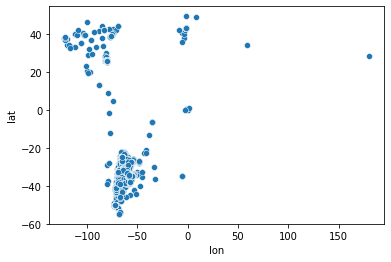

In [30]:
sns.scatterplot(data = df_train, x = 'lon', y = 'lat');

Capital tiene coordenadas 34.6132° S 58.3772° O aproximadamente

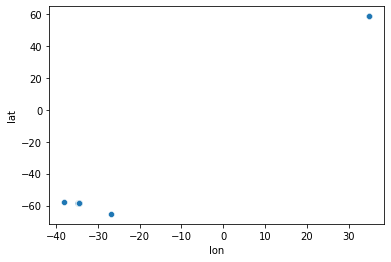

In [31]:
sns.scatterplot(data = df_pred, x = 'lon', y = 'lat');

Longitud: Oeste-Este. La distribución de la longitud parece ser normal. **Longitud y latitud parecen estar al revés** acá, debería ser -58.

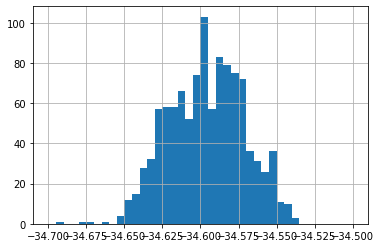

In [32]:
df_pred['lon'].hist(bins = 40, range = (-34.7,-34.5));

Latitud: Norte-Sur

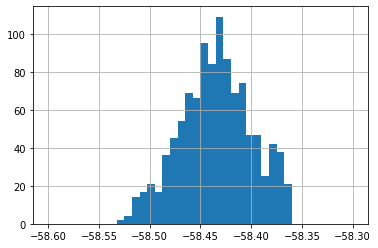

In [33]:
df_pred['lat'].hist(bins = 40, range = (-58.6,-58.3));
#revisar

No tiene información geográfica

In [34]:
(df_train.l3.isna() & (df_train.lon.isna() | df_train.lat.isna())).sum()

8289

###Tipos de propiedad

In [35]:
df_train.property_type.value_counts()

Departamento       457907
Casa               245726
Lote               121311
PH                  45837
Local comercial     45593
Oficina             32390
Otro                27837
Cochera             13276
Depósito             7872
Casa de campo        2251
Name: property_type, dtype: int64

Se necesita predecir el precio de departamentos y PHs (propiedades horizontales). No queda claro si otros tipos de propiedad pueden dar información sobre PHs (aunque se parecen a departamentos según esto: https://es.wikipedia.org/wiki/Ley_de_propiedad_horizontal; ver también esto https://www.iprofesional.com/actualidad/310324-por-que-los-ph-son-los-mas-elegidos).

In [36]:
df_pred.property_type.value_counts()

Departamento    823
PH              264
Name: property_type, dtype: int64

###Tipo de operación

In [37]:
df_train.operation_type.value_counts()

Venta                750831
Alquiler             207490
Alquiler temporal     41679
Name: operation_type, dtype: int64

Solo nos interesa ventas

In [38]:
df_pred.operation_type.value_counts()

Venta    1087
Name: operation_type, dtype: int64

###Período de precios

In [39]:
df_train.price_period.value_counts()

Mensual    429842
Semanal        17
Diario         11
Name: price_period, dtype: int64

Está vacío pero el tipo más frecuente es el mensual de todos modos

In [40]:
df_pred.price_period.value_counts()

Series([], Name: price_period, dtype: int64)

###Baños

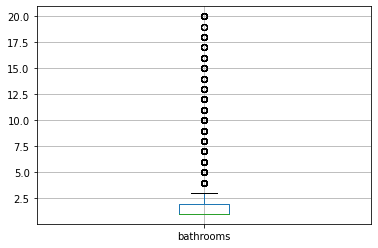

In [41]:
df_train.boxplot('bathrooms');

Filtrar más allá de 7, quizás entre 1 y 4

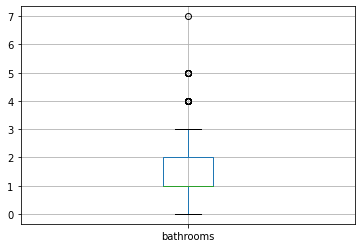

In [42]:
df_pred.boxplot('bathrooms');

In [43]:
for i in range(3,7):
  print((df_pred.bathrooms > i).sum())

26
7
1
1


In [44]:
(df_pred.bathrooms == 0).sum()

2

Errar a estos outlier podría tener bastante peso.


In [45]:
df_pred[df_pred.bathrooms > 4]

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,...,title,description,property_type,operation_type,details,additionals,services,l4,l5,l6
id,,,,,,,,,,,,,,,,,,,,,
28,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.465429,-34.625842,Argentina,Capital Federal,Flores,5.0,...,Gral. José Gervasio Artigas 400 - PH en Venta ...,"¡Imperdible oportunidad, PH de 250m2 en Flores...",PH,Venta,"Superficie 250m2, Ambientes 5, Baños 5, Dormit...",NaN,"Gas, Luz",NaN,NaN,NaN
31,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.467410,-34.594650,Argentina,Capital Federal,Paternal,11.0,...,Rafael Bielsa Al 200 - PH en Venta en Paternal...,"IMPECABLE PH CON ENTRADA INDEPENDIENTE, IDEAL ...",PH,Venta,"Superficie 180m2, Ambientes 11, Baños 5, Dormi...",Terraza,Gas,NaN,NaN,NaN
53,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.360796,-34.610501,Argentina,Capital Federal,Puerto Madero,4.0,...,"Torre Renoir Marta Lynch 489, Piso 31, Torre 1...",Excelente Semipiso en Torres Renoir ¨Residenci...,Departamento,Venta,"Superficie 177m2, Ambientes 4, Baños 5, Cocher...","Seguridad, Calefacción, SUM, Laundry, Gimnasio","Gas, Luz",NaN,NaN,NaN
161,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.447189,-34.564538,Argentina,Capital Federal,Belgrano,5.0,...,"Virrey Loreto Al 1900, Entre 3 De Febrero Y 11...","ULTIMO PISO, VISTA PANORÁMICA, TERRAZA PROPIA ...",Departamento,Venta,"Superficie 551.52m2, Ambientes 5, Baños 7, Coc...","Pileta, Seguridad, Calefacción, Balcón, Terraza","Gas, Luz",NaN,NaN,NaN
529,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.405688,-34.579589,Argentina,Capital Federal,Palermo,6.0,...,Libertador Al 2400 - Departamento en Venta en ...,Inmejorable piso en Av. Libertador 2400. El me...,Departamento,Venta,"Superficie 407m2, Ambientes 6, Baños 5, Cocher...","Pileta, Seguridad, Aire Acondicionado, SUM, La...","Gas, Luz",NaN,NaN,NaN
656,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.424358,-34.583577,Argentina,Capital Federal,Palermo,4.0,...,Thames Al 2200 - Departamento en Venta en Pale...,Exclusivo Penthouse en Torre Soho.<br>Distrubu...,Departamento,Venta,"Superficie 243m2, Ambientes 4, Baños 5, Cocher...","Pileta, Aire Acondicionado, SUM, Gimnasio, Ace...",Gas,NaN,NaN,NaN
675,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.458914,-34.579726,Argentina,Capital Federal,Colegiales,7.0,...,"Forest, Avda. 400 - PH en Venta en Colegiales,...","Importante ph en excelente ubicacion, entrada ...",PH,Venta,"Superficie 487m2, Ambientes 7, Baños 5, Dormit...","SUM, Balcón, Terraza",NaN,NaN,NaN,NaN


In [46]:
df_pred[df_pred.bathrooms == 0]

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,...,title,description,property_type,operation_type,details,additionals,services,l4,l5,l6
id,,,,,,,,,,,,,,,,,,,,,
991,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.426446,-34.591551,Argentina,Capital Federal,Palermo,2.0,...,Raúl Scalabrini Ortiz 1500 - Departamento en V...,¡Dos ambientes y cocina autónoma en el barrio ...,Departamento,Venta,"Superficie 37.45m2, Ambientes 2, Dormitorios 1...",NaN,"Gas, Luz",NaN,NaN,NaN
1003,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.373796,-34.601860,Argentina,Capital Federal,San Nicolás,5.0,...,San Martín 500 - Departamento en Venta en San ...,Descripción básica: <br>- Vivienda / Oficina d...,Departamento,Venta,"Superficie 468.61m2, Ambientes 5, Dormitorios ...","Aire Centralizado, Balcón, Terraza","Gas, Luz",NaN,NaN,NaN


In [47]:
df_pred.loc[991].description#tiene baño

'¡Dos ambientes y cocina autónoma en el barrio de Palermo Soho! <br><br>Descripción básica:<br>- Dos ambientes interno.<br>- Cocina autónoma.<br><br>Superficies:<br>- Cubierta: 37,45 m2.<br>-Total: 37,45 m2.<br><br>Descripción de ambientes:<br>- Living comedor.<br>- Baño completo.<br>- Habitación con placard.<br><br>Descripción del edificio: <br>- Edificio de 10 pisos.<br>- 4 unidades por piso.<br>- 1 ascensor.<br><br>Gastos:<br>-Expensas: $3.290.<br><br>Entrega:<br>- Actualmente se encuentra deshabitado.<br>- La documentación de la propiedad está en condiciones para la compraventa. <br><br>Accesibilidad:<br>-Colectivos: 15, 36, 39, 55, 57, 106, 110, 140, 141, 151, 160, 168.<br><br><br>Descripción del barrio:<br>-La propiedad se encuentra en el barrio de Palermo, que pertenece a la comuna 14 de la ciudad de Buenos Aires. A cuatro cuadras de Av. Córdoba y cuatro cuadras de Av. Honduras. En sus cercanías se encuentra la Plaza Serrano, la Plaza Armenia, la zona concurrida de Palermo Soho 

In [48]:
df_pred.loc[1003].description#supongo que cuenta como baño

'Descripción básica: <br>- Vivienda / Oficina de 6 ambientes.<br>- Amplio patio con posibilidad de construir y balcones al frente.<br>- Muy buen estado.<br><br>Superficies:<br>- Cubierta: 200,61.<br>- Descubierta: 262,01.<br>- Total: 468,71.<br><br>Distribución de ambientes: <br><br>- Vivienda / Oficina con doble circulación.<br>- Posee 3 toilette con ducha.<br>- Cocina independiente completa.<br>- Los ambientes se distribuyen por una parte como oficina y por otra parte como una vivienda.<br>- Posee 2 equipos de aire acondicionado central.<br><br>Descripción del edificio: <br>- 100 años de antigüedad. <br>- Departamento de 7 pisos. <br>- 2 unidades por piso.<br><br>Gastos: <br>- Expensas: $ 18.000 (El agua esta incluida).<br> <br>Entrega:<br>- Entrega AD inmediata.<br>- La documentación de la propiedad está en condiciones para la compraventa. <br><br>Accesibilidad:<br>- Colectivos: 4, 5, 6, 7, 9, 22, 23, 26, 28, 33, 45, 50, 56, 61, 62, 91, 93, 99, 109, 115, 126, 130, 132, 140, 143, 146

###Ambientes

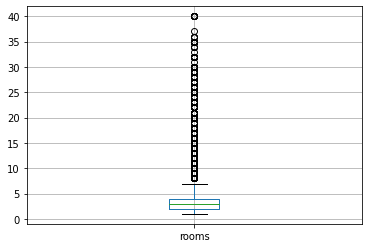

In [49]:
df_train.boxplot('rooms');

Filtrar más allá de 13, quizás entre 1 y 7/8/9

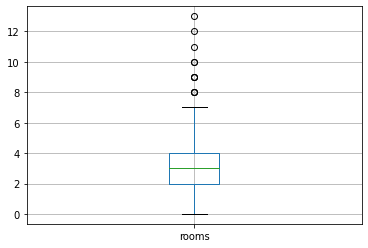

In [50]:
df_pred.boxplot('rooms');

In [51]:
for i in range(5,12):  
  print((df_pred.rooms > i).sum())

53
22
11
8
5
3
2


In [52]:
(df_pred.rooms == 0).sum()

1

In [53]:
df_pred[df_pred.rooms > 7]

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,...,title,description,property_type,operation_type,details,additionals,services,l4,l5,l6
id,,,,,,,,,,,,,,,,,,,,,
31,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.467410,-34.594650,Argentina,Capital Federal,Paternal,11.0,...,Rafael Bielsa Al 200 - PH en Venta en Paternal...,"IMPECABLE PH CON ENTRADA INDEPENDIENTE, IDEAL ...",PH,Venta,"Superficie 180m2, Ambientes 11, Baños 5, Dormi...",Terraza,Gas,NaN,NaN,NaN
217,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.401435,-34.630072,Argentina,Capital Federal,Boedo,8.0,...,"Inclan Al 2600 - PH en Venta en Boedo, CABA de...","A 20 metros de la estación Inclan, nueva línea...",PH,Venta,"Superficie 338m2, Ambientes 8, Baños 2, Dormit...","SUM, Balcón, Terraza","Gas, Luz",NaN,NaN,NaN
226,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.440070,-34.578500,Argentina,Capital Federal,Palermo,9.0,...,"Dorrego 2100, Palermo Hollywood - PH en Venta ...",Imperdible PH con entrada independiente en una...,PH,Venta,"Superficie 200m2, Ambientes 9, Baños 3, Dormit...","Aire Acondicionado, Aceptan Mascotas, Terraza","Gas, Luz",NaN,NaN,NaN
240,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.524960,-34.639428,Argentina,Capital Federal,Liniers,10.0,...,"Carhue 28 - Departamento en Venta en Liniers, ...",TODOS LOS GASTOS DE ESCRITURACION CORREN POR C...,Departamento,Venta,"Superficie 286m2, Ambientes 10, Baños 3, Sup. ...",SUM,"Gas, Luz",NaN,NaN,NaN
334,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.398016,-34.594166,Argentina,Capital Federal,Recoleta,9.0,...,Uriburu Jose.e..pte.1216 - Departamento en Ve...,OPORTUNIDAD única en el mercado!!!!!. Propieda...,Departamento,Venta,"Superficie 378m2, Ambientes 9, Baños 3, Dormit...","Laundry, Family Room",Gas,NaN,NaN,NaN
403,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.388392,-34.600541,Argentina,Capital Federal,San Nicolás,12.0,...,Viamonte 1500 - Departamento en Venta en San N...,¡Excelente piso/oficina de 12 ambientes en Tri...,Departamento,Venta,"Superficie 244.39m2, Ambientes 12, Baños 2, Do...","Aire Centralizado, Aire Acondicionado","Gas, Luz",NaN,NaN,NaN
522,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.377677,-34.609106,Argentina,Capital Federal,Monserrat,13.0,...,"Piedras - Departamento en Venta en Monserrat, ...","Gran propiedad, apta profesional, con excelent...",Departamento,Venta,"Superficie 308.84m2, Ambientes 13, Baños 2, Do...","Calefacción, Aire Centralizado, Aire Acondicio...","Gas, Luz",NaN,NaN,NaN
525,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.431966,-34.603452,Argentina,Capital Federal,Almagro,10.0,...,"Anibal Troilo Al 900 - PH en Venta en Almagro,...","En excelente ubicación, el mejor punto de Alma...",PH,Venta,"Superficie 314.74m2, Ambientes 10, Baños 4, Do...","Balcón, Terraza",NaN,NaN,NaN,NaN
541,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.391222,-34.590581,Argentina,Capital Federal,Recoleta,9.0,...,Vicente Lopez Al 1800 - Departamento en Venta ...,UNICO DUPLEX en venta en el barrio de RECOLETA...,Departamento,Venta,"Superficie 460m2, Ambientes 9, Baños 4, Cocher...","Aire Acondicionado, Laundry, Balcón, Terraza","Gas, Luz",NaN,NaN,NaN


In [54]:
df_pred.loc[541].description

'UNICO DUPLEX en venta en el barrio de RECOLETA en VENTA con TERRAZA PROPIA!!<br><br>Se distribuye en dos plantas con 500m2 de superficie total.<br><br>En la planta principal:<br>Cuenta con living y comedor al frente de calle con salida a 3 balcones, espacio de escritorio, dormitorio principal en suite anexo a una sala de estar amplia (que en realidad SERIA el espacio para el dormitorio principal). Luego cuenta con la antesala a otros dos dormitorios con vista al contrafrente y un baño completo. Cocina y comedor diario. Esta planta cuenta con TRIPLE CIRCULACION. Cuenta ademas con ascensor de servicio. Estufa a leña en el living.<br><br>La escalera en mármol de carrara conecta con la planta alta. Salida a la terraza de 100m2 de USO EXCLUSIVO con parrilla y orientación ESTE. Muy luminosa, sobre toda en la mañana.<br><br>Planta Alta:<br>Cuenta con la sala de estar, que conecta a un dormitorio, sala de escritorio y baño completo. Y luego el corredor que lleva a otros dos dormitorios y su b

In [55]:
df_pred[df_pred.rooms == 0]#tiene varias habitaciones actualmente

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,...,title,description,property_type,operation_type,details,additionals,services,l4,l5,l6
id,,,,,,,,,,,,,,,,,,,,,
794,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.36167,-34.815962,Argentina,Capital Federal,Palermo,0.0,...,"Carranza A.j. 1900 - PH en Venta en Palermo, C...",VENTA DE PH AL FRENTE DE 3 PLANTAS EN PALERMO ...,PH,Venta,"Superficie 228m2, Baños 1, Dormitorios 5, Sup....","SUM, Balcón, Terraza","Gas, Luz",NaN,NaN,NaN


In [56]:
df_pred.loc[794].description

'VENTA DE PH AL FRENTE DE 3 PLANTAS EN PALERMO HOLLYWOOD - PLANTA BAJA: HAY 2 LOCALES DE NEGOCIOS DE APROXIMADAMENTE 24m2 y 25m2 RESPECTIVAMENTE y UNA VIVIENDA DE 1 AMBIENTE CON PATIO PEQUEÑO SUMANDO UNA SUPERFICIE TOTAL EN PLANTA BAJA DE 88m2,. - EN PRIMER PISO: HAY 1 DEPARTAMENTO DE 3 AMBIENTES COMPUESTO DE LIVING COMEDOR, 2 DORMITORIOS. COCINA, BAÑO COMPLETO, TERRAZA CON PARRILLA, Y BALCON CORRIDO AL FRENTE.. - EN SEGUNDO PISO: HAY 1 DEPARTAMENTO DE 3 AMBIENTES, COMPUESTO DE LIVING COMEDOR, 2 DORMITORIOS, COCINA, BAÑO COMPLETO, TERRAZA, BALCON CORRIDO AL FRENTE. TOTAL 5 UNIDADES INDEPENDIENTES SIN SUBDIVIDIR. COMUNICACION VERTICAL X ESCALERA. SUPERFICIE TOTAL APROXIMADA ACTUAL: 228m2 -'

###Dormitorios

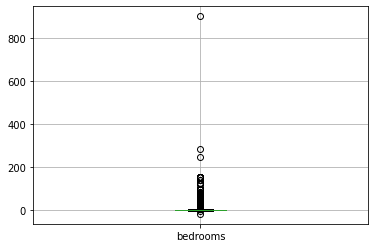

In [57]:
df_train.boxplot('bedrooms');

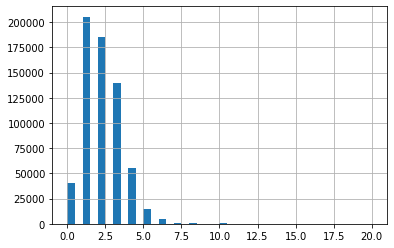

In [58]:
df_train.bedrooms.hist(bins = 40, range = (0,20));

Filtrar más allá de 12, quizás entre 1 y 6/7

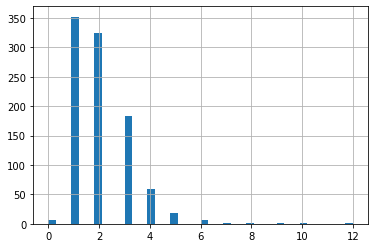

In [59]:
df_pred.bedrooms.hist(bins = 40);

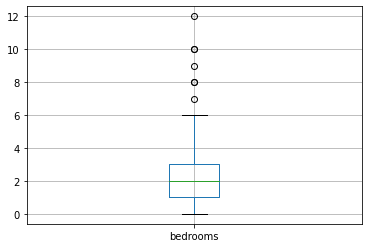

In [60]:
df_pred.boxplot('bedrooms');

In [61]:
for i in range(4,11):
  print((df_pred.bedrooms > i).sum())

32
13
7
6
4
3
1


In [62]:
(df_pred.bedrooms == 0).sum()

7

In [63]:
df_pred[df_pred.bedrooms > 9]

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,...,title,description,property_type,operation_type,details,additionals,services,l4,l5,l6
id,,,,,,,,,,,,,,,,,,,,,
28,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.465429,-34.625842,Argentina,Capital Federal,Flores,5.0,...,Gral. José Gervasio Artigas 400 - PH en Venta ...,"¡Imperdible oportunidad, PH de 250m2 en Flores...",PH,Venta,"Superficie 250m2, Ambientes 5, Baños 5, Dormit...",NaN,"Gas, Luz",NaN,NaN,NaN
31,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.467410,-34.594650,Argentina,Capital Federal,Paternal,11.0,...,Rafael Bielsa Al 200 - PH en Venta en Paternal...,"IMPECABLE PH CON ENTRADA INDEPENDIENTE, IDEAL ...",PH,Venta,"Superficie 180m2, Ambientes 11, Baños 5, Dormi...",Terraza,Gas,NaN,NaN,NaN
403,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.388392,-34.600541,Argentina,Capital Federal,San Nicolás,12.0,...,Viamonte 1500 - Departamento en Venta en San N...,¡Excelente piso/oficina de 12 ambientes en Tri...,Departamento,Venta,"Superficie 244.39m2, Ambientes 12, Baños 2, Do...","Aire Centralizado, Aire Acondicionado","Gas, Luz",NaN,NaN,NaN


En general son monoambientes

In [64]:
df_pred[df_pred.bedrooms == 0]

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,...,title,description,property_type,operation_type,details,additionals,services,l4,l5,l6
id,,,,,,,,,,,,,,,,,,,,,
55,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.450791,-34.610109,Argentina,Capital Federal,Caballito,1.0,...,Pujol 1095 - Departamento en Venta en Caballit...,ESPECTACULAR MONOAMBIENTE A ESTRENAR DE 38 met...,Departamento,Venta,"Superficie 38m2, Ambientes 1, Baños 1, Sup. Cu...","SUM, Balcón, Terraza","Gas, Luz",NaN,NaN,NaN
229,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.513376,-34.623151,Argentina,Capital Federal,Monte Castro,1.0,...,Av. Lope De Vega 1800 - Departamento en Venta ...,Descripción básica:<br>-¡Departamento monoambi...,Departamento,Venta,"Superficie 38m2, Ambientes 1, Baños 1, Sup. Cu...",NaN,NaN,NaN,NaN,NaN
616,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.510573,-34.620854,Argentina,Capital Federal,Monte Castro,1.0,...,Cervantes 2000 - Departamento en Venta en Mont...,Descripción básica:<br>VENTA DEPARTAMENTO MONO...,Departamento,Venta,"Superficie 34m2, Ambientes 1, Baños 1, Sup. Cu...",NaN,"Gas, Luz",NaN,NaN,NaN
648,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.513376,-34.623151,Argentina,Capital Federal,Monte Castro,1.0,...,Av. Lope De Vega 1800 - Departamento en Venta ...,Descripción básica:<br>-¡Departamento monoambi...,Departamento,Venta,"Superficie 38m2, Ambientes 1, Baños 1, Sup. Cu...",Balcón,NaN,NaN,NaN,NaN
770,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.407678,-34.619566,Argentina,Capital Federal,Balvanera,1.0,...,La Rioja 1100 - Departamento en Venta en Balva...,Descripción básica: <br>- Departamento monoamb...,Departamento,Venta,"Superficie 31.12m2, Ambientes 1, Baños 1, Sup....","Seguridad, Calefacción, Aceptan Mascotas","Gas, Luz",NaN,NaN,NaN
861,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.452433,-34.625189,Argentina,Capital Federal,Caballito,1.0,...,Av. Rivadavia 6100 - Departamento en Venta en ...,Descripción básica: <br>- Monoambiente divisib...,Departamento,Venta,"Superficie 41.33m2, Ambientes 1, Baños 1, Sup....",NaN,"Gas, Luz",NaN,NaN,NaN
1082,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.507506,-34.587414,Argentina,Capital Federal,Villa Pueyrredon,1.0,...,Cuenca 4800 - Departamento en Venta en Villa P...,Departamento monoambiente divisible con balcón...,Departamento,Venta,"Superficie 38m2, Ambientes 1, Baños 1, Cochera...",NaN,"Gas, Luz",NaN,NaN,NaN


###Fecha de finalización del aviso

In [65]:
df_train.end_date.value_counts()

9999-12-31    208960
2021-06-05     70852
2021-04-09     23315
2020-10-03     15205
2020-09-04     14608
               ...  
2021-06-20        83
2020-05-27        72
2020-06-07        66
2020-05-24        29
2020-08-22         1
Name: end_date, Length: 450, dtype: int64

###Superficie

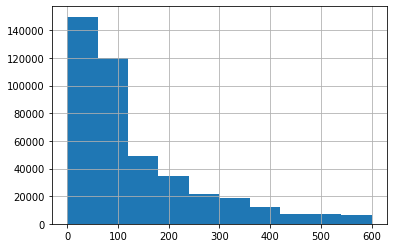

In [66]:
df_train.surface_total.hist(range = (0,600));

In [67]:
(df_train.surface_total > 600).sum()

50930

Quizás un límite razonable para filtrar es 600m2/500m2

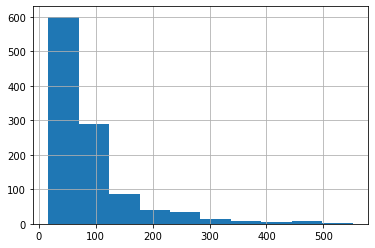

In [68]:
df_pred.surface_total.hist();

In [69]:
for s in [300,400,500]:
  print((df_pred.surface_total > s).sum())

32
14
3


Los monoambientes tienen superficies desde 35m2 pero aparentemente puede haber algunas cosas más chicas que eso: http://clavesdeco.puraciudad.com.ar/como-son-los-nuevos-micro-departamentos-de-buenos-aires/
Quizás para ciertos tipos de propiedad tenga sentido, pero no para Departamentos y PH.

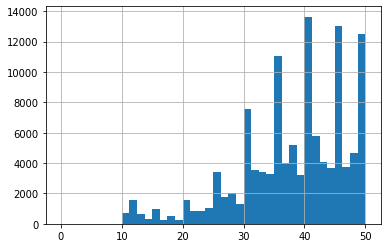

In [70]:
df_train.surface_total.hist(range = (0,50), bins = 40);

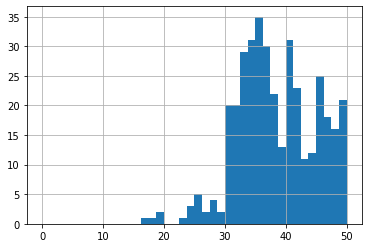

In [71]:
df_pred.surface_total.hist(range = (0,50), bins = 40);

Quizás podría filtrarse superficies menores a 30m2/25m2

In [72]:
for i in [15,20,25,30]:
  print((df_pred.surface_total < i).sum())

0
4
8
21


Dado df_pred, los filtros para superficie cubierta deberían ser iguales.

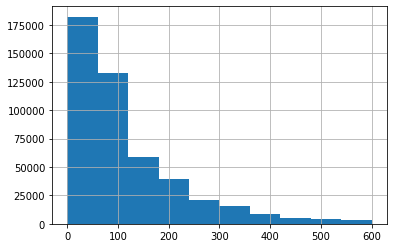

In [73]:
df_train.surface_covered.hist(range = (0,600));

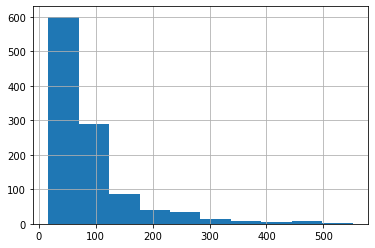

In [74]:
df_pred.surface_covered.hist();

In [75]:
for s in [300,400,500]:
  print((df_pred.surface_covered > s).sum())

32
14
3


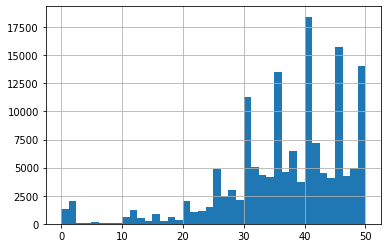

In [76]:
df_train.surface_covered.hist(range = (0,50), bins = 40);

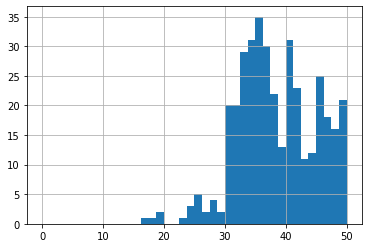

In [77]:
df_pred.surface_total.hist(range = (0,50), bins = 40);

In [78]:
for i in [15,20,25,30]:
  print((df_pred.surface_covered < i).sum())

0
4
8
21


Parece dudoso que se necesite ambas superficies, aunque sean diferentes para df_train. Hay que analizarlo.

In [79]:
mask = (df_train.surface_covered > 0) & (df_train.surface_total > 0)
df_train[mask].surface_covered.corr(df_train[mask].surface_total)

0.42886806735164545

Sugiere imputar una de las superficies con la otra

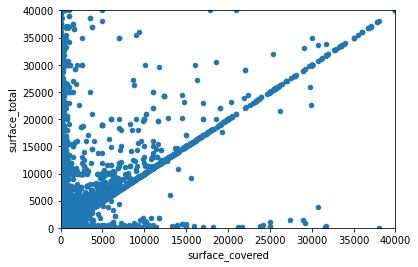

In [80]:
df_train.plot.scatter(x = 'surface_covered', y = 'surface_total', xlim = (0,40000),ylim = (0,40000));

In [81]:
(df_train.surface_total-df_train.surface_covered).describe()

count     422807.000000
mean         143.401472
std         3291.558475
min     -1000000.000000
25%            0.000000
50%            4.000000
75%           20.000000
max       199998.000000
dtype: float64

In [82]:
(df_train.surface_total > df_train.surface_covered).sum()

244611

En el conjunto a predecir ambas tienden a ser iguales

In [83]:
(df_pred.surface_total-df_pred.surface_covered).describe()

count    1087.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
dtype: float64

No hay evidencia de similitud entre distribuciones así que no hay razón para descartar alguna de las columnas, cualquiera puede ser útil (quizás quiera normalizarlo primero).

In [84]:
U,p = sp.stats.mannwhitneyu(df_train[df_train.surface_covered < 600].surface_covered, df_pred.surface_covered)
print('p-valor es ',p)

p-valor es  1.1574415255953893e-10


In [85]:
U,p = sp.stats.mannwhitneyu(df_train[df_train.surface_total < 600].surface_total, df_pred.surface_total)
print('p-valor es ',p)

p-valor es  1.8589638559315343e-25


###Avisos duplicados

¿No hay avisos duplicados? (ver explicación de id en properati)

In [86]:
#idx = pd.Index(['lama', 'cow', 'lama', 'beetle', 'lama'])
#idx.duplicated().any() #devuelve true porque hay índices repetidos
df_train.index.duplicated().any()

False

In [87]:
df_pred.index.duplicated().any()

False

In [88]:
df_train.duplicated().sum()

20838

In [89]:
df_pred.duplicated().sum()

59

In [90]:
df_train.title.duplicated().sum()

451166

###Precios

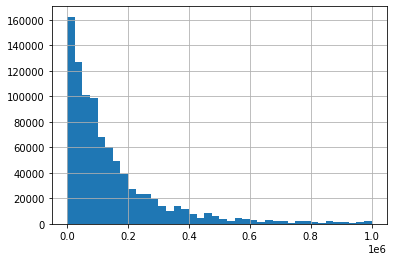

In [91]:
df_train.price.hist(bins = 40, range=(0,1000000));

Explorar precios bajos cuando se filtre la base de datos

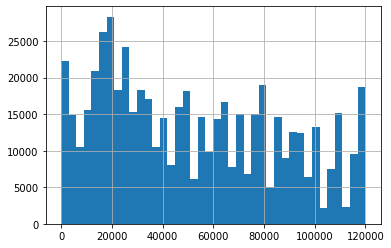

In [92]:
df_train.price.hist(bins = 40, range=(-100,120000));

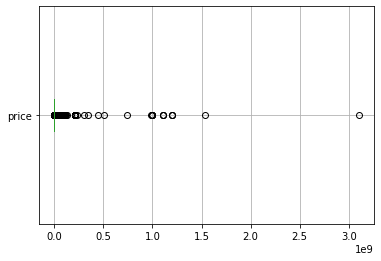

In [93]:
df_train.boxplot('price', vert = False);

Parece que hay pocos outliers y la mayoría es simplemente la cola larga de la exponencial.

In [94]:
for i in [2500000,5000000,10000000,100000000]:
  print((df_train.price > i).sum())

15932
9063
3652
79


In [95]:
for i in [2500,5000,7500,10000,25000]:
  print((df_train.price < i).sum())

18535
33318
42047
51837
162423


El logaritmo normaliza a la variable precio, puede que sea util. Ojo con los infinitos igual (puede que sea causado por outliers).

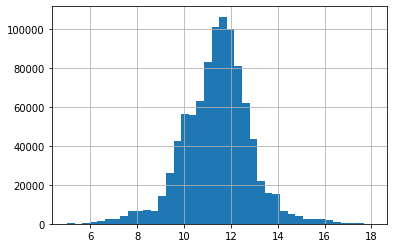

In [96]:
df_train.price.apply(np.log).hist(bins = 40, range = (5,18));

In [97]:
(df_train.price.apply(np.log) < 0).sum()

2900

###Precios por m2

La distribución de precios por metro cuadrado muestra que la mayoría de estos son alrededor de 2000USD/m2. Zona norte y zona sur se alejan de esa tendencia y Puerto Madero claramente es un outlier.

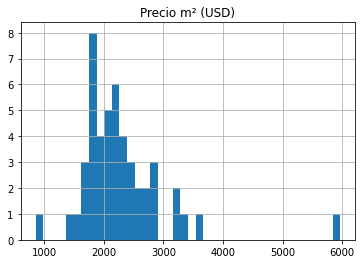

In [98]:
df_usdpersqm.loc[:,2022,4].hist(bins = 40);

In [99]:
df_usdpersqm.loc[:,2022,4][df_usdpersqm > 3000].dropna()

,,,Precio m² (USD)
Barrio,Año,Mes,
Puerto Madero,2022,4,5968.573965
Palermo,2022,4,3601.155345
Núñez,2022,4,3196.101131
Belgrano,2022,4,3363.736852
Retiro,2022,4,3249.283776


In [100]:
df_usdpersqm.loc[:,2022,4][df_usdpersqm < 1700].dropna()

,,,Precio m² (USD)
Barrio,Año,Mes,
Nueva Pompeya,2022,4,1666.666667
Versalles,2022,4,1562.500000
Constitución,2022,4,1660.039775
Boca,2022,4,1400.950577
Villa Lugano,2022,4,854.311518


El análisis directamente desde df_train no es aconcejable hasta no ajustar precios a una fecha específica.

In [101]:
df_usdpersqm.loc[:,2022,4].head(50)

,,,Precio m² (USD)
Barrio,Año,Mes,
Puerto Madero,2022,4,5968.573965
Palermo,2022,4,3601.155345
Núñez,2022,4,3196.101131
Belgrano,2022,4,3363.736852
Retiro,2022,4,3249.283776
Recoleta,2022,4,2811.879119
Colegiales,2022,4,2716.278837
Villa Urquiza,2022,4,2770.023960
Coghlan,2022,4,2811.106524


###Título de aviso

(Poco aconsejable analizar directamente la base de datos entera por este método)
No parece haber información demasiado útil. Mayoritariamente direcciones y algunos datos básicos.

In [102]:
df_pred_title = df_pred['title'].astype(str).str.lower()

In [103]:
regexp = RegexpTokenizer('\w+')
df_pred_title = df_pred_title.apply(regexp.tokenize)

In [104]:
stopwords = nltk.corpus.stopwords.words("spanish")
stopwords.extend(['es', 'osea', 'sólo','br'])

df_pred_title = df_pred_title.apply(lambda texto: [token for token in texto if token not in stopwords])
#df_pred["description"]

In [105]:
df_pred_title = df_pred_title.str.join(' ')

In [106]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), min_df=0.005, max_df=0.7, strip_accents='ascii', max_features=2000, lowercase = False)
vectorized_data = vectorizer.fit_transform(df_pred_title)

In [107]:
count_df_pred_t = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out(), index = df_pred.index)

In [108]:
count_df_pred_t.sum().sort_values(ascending = False).head(50)

bano           757
dormitorios    599
dormitorio     352
banos          324
ph             276
palermo        218
villa          157
av             122
belgrano       119
recoleta       100
caballito       77
san             73
1400            63
crespo          58
almagro         58
800             57
moldes          41
arevalo         41
nunez           41
barracas        39
urquiza         37
flores          36
200             36
34              35
36              35
400             35
balvanera       34
1000            34
parque          33
100             30
1300            30
1200            29
35              28
55              28
33              27
colegiales      27
40              27
sup             27
38              26
2200            25
1800            25
47              25
telmo           25
saavedra        24
paraguay        23
1500            23
45              23
1600            23
700             22
boedo           21
dtype: int64

###Descripción

(Poco aconsejable analizar directamente la base de datos entera por este método)

In [109]:
df_pred_description = df_pred['description'].astype(str).str.lower()

In [110]:
regexp = RegexpTokenizer('\w+')
df_pred_description = df_pred_description.apply(regexp.tokenize)

In [111]:
stopwords = nltk.corpus.stopwords.words("spanish")
stopwords.extend(['es', 'osea', 'sólo','br','nbsp'])

df_pred_description = df_pred_description.apply(lambda texto: [token for token in texto if token not in stopwords])

In [112]:
df_pred_description = df_pred_description.str.join(' ')

In [113]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), min_df=0.005, max_df=0.7, strip_accents='ascii', max_features=2000, lowercase = False)
vectorized_data = vectorizer.fit_transform(df_pred_description)

In [114]:
count_df_pred_d = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out(), index = df_pred.index)

In [115]:
count_df_pred_d.sum().sort_values(ascending = False).head(50)

ambientes        1419
m2               1081
piso             1021
propiedad        1018
bano              992
expensas          979
comedor           918
av                878
living            831
balcon            799
inmueble          736
edificio          733
departamento      732
medidas           671
pisos             664
completo          646
encuentra         594
unidades          587
ley               584
frente            580
excelente         575
dos               571
caso              557
descripcion       544
dormitorio        502
cuenta            501
entrega           491
barrio            476
amplio            469
dormitorios       460
terraza           452
lavadero          428
ser               415
luminoso          414
profesional       414
tratarse          414
superficie        409
patio             398
ubicacion         395
linea             395
matricula         391
metros            391
sujetos           390
independiente     388
valor             387
puede     

In [116]:
count_df_pred_d.sum().sort_values(ascending = False).to_csv('keyword_description_pred.csv')

###Otras columnas textuales del conjunto a predecir

Detalles

Parece solo tener información sobre cocheras

In [117]:
df_pred_details = df_pred['details'].astype(str).str.lower()

In [118]:
regexp = RegexpTokenizer('\w+')
df_pred_details = df_pred_details.apply(regexp.tokenize)

In [119]:
stopwords = nltk.corpus.stopwords.words("spanish")
stopwords.extend(['es', 'osea', 'sólo','br','nbsp'])

df_pred_details = df_pred_details.apply(lambda texto: [token for token in texto if token not in stopwords])

In [120]:
df_pred_details = df_pred_details.str.join(' ')

In [121]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), min_df=0.005, max_df=0.7, strip_accents='ascii', max_features=2000, lowercase = False)
vectorized_data = vectorizer.fit_transform(df_pred_details)

In [122]:
count_df_pred_de = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out(), index = df_pred.index)

In [123]:
count_df_pred_de.sum().sort_values(ascending = False).head(50)

anos             747
pisos            603
cantidad         603
toilette         264
cocheras         175
piso             163
departamentos    163
antiguedad40      81
antiguedad60      73
antiguedad50      72
5m2               62
10                62
antiguedad45      53
orientacion       51
31                46
38m2              39
72m2              38
7m2               37
75m2              37
36                36
6m2               35
antiguedad30      34
45m2              31
55m2              31
34                31
33m2              31
8m2               31
32                30
antiguedad70      30
antiguedad10      30
40m2              29
35                29
85m2              29
80m2              28
14                28
apto              27
35m2              27
profesionalsi     27
64m2              26
65m2              26
68m2              26
62m2              26
40                25
60m2              25
58m2              25
34m2              23
antiguedad20      23
antiguedad52 

In [124]:
count_df_pred_de.sum().sort_values(ascending = False).to_csv('keyword_details_pred.csv')

Adicionales

Hay algunos candidatos a generar dummies (balcón, terraza, mascota, pileta, patio, aire acondicionado, SUM, laundry, gimnasio, calefacción, seguridad/alarma)

In [125]:
df_pred_additionals = df_pred['additionals'].astype(str).str.lower()

In [126]:
regexp = RegexpTokenizer('\w+')
df_pred_additionals = df_pred_additionals.apply(regexp.tokenize)

In [127]:
stopwords = nltk.corpus.stopwords.words("spanish")
stopwords.extend(['es', 'osea', 'sólo','br','nbsp'])

df_pred_additionals = df_pred_additionals.apply(lambda texto: [token for token in texto if token not in stopwords])

In [128]:
df_pred_additionals = df_pred_additionals.str.join(' ')

In [129]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), min_df=0.005, max_df=0.7, strip_accents='ascii', max_features=2000, lowercase = False)
vectorized_data = vectorizer.fit_transform(df_pred_additionals)

In [130]:
count_df_pred_a = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out(), index = df_pred.index)

In [131]:
count_df_pred_a.sum().sort_values(ascending = False).head(50)

balcon           512
terraza          418
aire             305
acondicionado    297
sum              296
mascotas         259
aceptan          259
pileta           144
patio            139
laundry          137
nan              132
gimnasio         101
calefaccion       66
seguridad         59
alarma            18
centralizado       8
family             6
room               6
dtype: int64

In [132]:
count_df_pred_a.sum().sort_values(ascending = False).to_csv('keyword_additionals_pred.csv')

Servicio

Podría generar dos dummies si hay información similar en la base de datos de Properati.

In [133]:
df_pred_services = df_pred['services'].astype(str).str.lower()

In [134]:
regexp = RegexpTokenizer('\w+')
df_pred_services = df_pred_services.apply(regexp.tokenize)

In [135]:
stopwords = nltk.corpus.stopwords.words("spanish")
stopwords.extend(['es', 'osea', 'sólo','br','nbsp'])

df_pred_services = df_pred_services.apply(lambda texto: [token for token in texto if token not in stopwords])

In [136]:
df_pred_services = df_pred_services.str.join(' ')

In [137]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), min_df=0.005, max_df=0.7, strip_accents='ascii', max_features=2000, lowercase = False)
vectorized_data = vectorizer.fit_transform(df_pred_services)

In [138]:
count_df_pred_s = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out(), index = df_pred.index)

In [139]:
count_df_pred_s.sum().sort_values(ascending = False).head(50)

gas    720
luz    706
nan    245
dtype: int64

# Tratamiento de los datos

In [140]:
df_t = df_train.copy()
df_p = df_pred.copy()

##Primer filtrado de la base de datos y arreglos básicos

###Filtrado de datos

Estos filtros están perfectos, aún así ver si se puede recuperar precio desde los avisos

In [141]:
# seleccion de datos de demostración. cambiar
df_t = df_t.loc[(df_t.l1 == "Argentina") & (df_t.l2 == "Capital Federal") & (df_t.operation_type == 'Venta') & ((df_t.property_type == 'Departamento') | (df_t.property_type == 'PH'))]
df_t.drop(columns = ['ad_type','l1','l2','l5','l6'], inplace = True)
df_t.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(147625, 19)

In [142]:
df_p.drop(columns = ['ad_type','l1','l2','l5','l6'], inplace = True)
#df_p.drop(columns = ['Details','Additionals','Services'], inplace = True)#ojo, puede tener algo de información relevante

###Arreglo las columnas de las coordenadas para el conjunto de predicción

In [143]:
df_p.rename(columns = {"lon":"lat","lat":"lon"},inplace = True)

###Arreglo Barrios

Arreglo l3 y lleno l4 donde haga sentido. Utilicé zonaprops para tener una idea cuáles tienen precio por m2 similar.

In [144]:
neighborhood_dict = {'Abasto' : 'Balvanera', 'Congreso' : 'Balvanera','Once' : 'Balvanera',
                     'Pompeya' : 'Nueva Pompeya',
                     'Nuñez' : 'Núñez',
                     'Las Cañitas': 'Palermo','2 Ambientes': 'Palermo',
                     'Barrio Norte': 'Recoleta',
                     'Catalinas': 'Retiro','Centro / Microcentro': 'Retiro',
                     'GBA Norte': 'Saavedra',
                     'San Cristobal':'San Cristóbal',
                     'Tribunales':'San Nicolás',
                     'Parque Centenario': 'Villa Crespo',
                     'Velez Sarsfield':'Vélez Sarsfield',
                     'Villa Ortuzar': 'Villa Ortúzar',
                     'Villa Pueyrredon': 'Villa Pueyrredón'}

In [145]:
notl4list = ['Núñez','Pompeya','San Cristobal','Villa Ortuzar','Villa Pueyrredon','Velez Sarsfield','2 Ambientes']

In [146]:
def neighborhood_fix(row,n_dict,notl4list):
  if(pd.notna(row.l3) and (row.l3 in n_dict.keys())):
    if(not (row.l3 in notl4list)):
      row.l4 = row.l3
    row.l3 = n_dict[row.l3]
  return row

In [147]:
df_t = df_t.apply(lambda x: neighborhood_fix(x,neighborhood_dict,notl4list),axis = 'columns')

In [148]:
df_p = df_p.apply(lambda x: neighborhood_fix(x,neighborhood_dict,notl4list),axis = 'columns')

###Conversión de precios a Abril de 2022

Divido por el precio por unidad de superficie de un mes específico y lo multiplico por el de abril de 2022 para ajustar los precios.

In [149]:
def price_converter(row,new_year,new_month,df_usdpersqm):
  if(pd.notna(row.l3)):
    row['price'] = row['price'] * float(df_usdpersqm.loc[row.l3,new_year,new_month]) / float(df_usdpersqm.loc[row.l3,row.created_on.year,row.created_on.month])
  return row

In [150]:
float(df_usdpersqm.loc['Villa Soldati',2021,2])

1268.5967657798644

In [151]:
df_t = df_t.apply(lambda x: price_converter(x,2022,4,df_usdpersqm),axis = 'columns')

###Estadísticas descriptivas de properati filtrado

In [152]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147625 entries, U3qdJMKXnOJm0Y1tWpnnfg== to No3is+HhwUGlfgQfzsZbdg==
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   start_date       147625 non-null  datetime64[ns]
 1   end_date         147625 non-null  object        
 2   created_on       147625 non-null  datetime64[ns]
 3   lat              138700 non-null  float64       
 4   lon              138700 non-null  float64       
 5   l3               147016 non-null  object        
 6   l4               19437 non-null   object        
 7   rooms            140422 non-null  float64       
 8   bedrooms         123074 non-null  float64       
 9   bathrooms        140769 non-null  float64       
 10  surface_total    100529 non-null  float64       
 11  surface_covered  101841 non-null  float64       
 12  price            145536 non-null  float64       
 13  currency         145342 non-null  obje

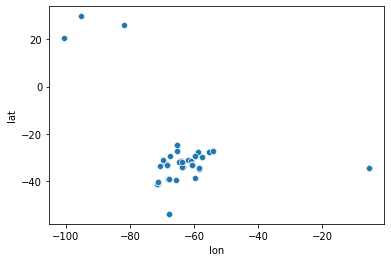

In [153]:
sns.scatterplot(data = df_t, x = 'lon', y = 'lat');

In [154]:
df_t.describe(datetime_is_numeric = True)

,start_date,created_on,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,147625,147625,138700.000000,138700.000000,140422.000000,123074.000000,140769.000000,100529.000000,101841.000000,1.455360e+05
mean,2020-12-02 18:21:00.225571584,2020-12-02 18:21:00.225571584,-34.593454,-58.446154,2.664582,1.887978,1.497830,111.855524,90.172190,2.234368e+05
min,2020-05-24 00:00:00,2020-05-24 00:00:00,-53.788624,-100.469651,1.000000,-1.000000,1.000000,10.000000,1.000000,0.000000e+00
25%,2020-08-30 00:00:00,2020-08-30 00:00:00,-34.614646,-58.463032,2.000000,1.000000,1.000000,44.000000,40.000000,9.069601e+04
50%,2020-11-19 00:00:00,2020-11-19 00:00:00,-34.595045,-58.439021,3.000000,2.000000,1.000000,64.000000,56.000000,1.350372e+05
75%,2021-03-23 00:00:00,2021-03-23 00:00:00,-34.576052,-58.410345,3.000000,3.000000,2.000000,100.000000,85.000000,2.218347e+05
max,2021-06-17 00:00:00,2021-06-17 00:00:00,29.753374,-5.490771,35.000000,153.000000,18.000000,140380.000000,123000.000000,1.110000e+08
std,NaN,NaN,0.321520,0.385287,1.327704,1.409456,0.823584,1173.611459,929.303025,6.337717e+05


In [155]:
df_t.describe(include = 'object')

,end_date,l3,l4,currency,price_period,title,description,property_type,operation_type
count,147625,147016,19437,145342,69824,147625,147625,147625,147625
unique,447,48,14,2,1,78412,113923,2,1
top,9999-12-31,Palermo,Barrio Norte,USD,Mensual,Departamento - Palermo,Pozo en Villa Crespo. Monoambientes y Versátil...,Departamento,Venta
freq,26158,22823,4526,145189,69824,1118,98,134044,147625


Correlaciones similares a las vistas en el conjunto a predecir entre habitaciones, pero no tanto para superficies con habitaciones. Puede que haya outliers en ese sentido.

In [156]:
df_t.corr()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
lat,1.000000,-0.317267,-0.003101,0.001752,0.017956,0.002875,0.002591,0.000277
lon,-0.317267,1.000000,0.007277,0.009313,0.014616,-0.005972,-0.004167,0.003077
rooms,-0.003101,0.007277,1.000000,0.890039,0.632530,0.050556,0.052084,0.211179
bedrooms,0.001752,0.009313,0.890039,1.000000,0.628266,0.048047,0.048596,0.177217
bathrooms,0.017956,0.014616,0.632530,0.628266,1.000000,0.054176,0.050484,0.301848
surface_total,0.002875,-0.005972,0.050556,0.048047,0.054176,1.000000,0.862668,0.026788
surface_covered,0.002591,-0.004167,0.052084,0.048596,0.050484,0.862668,1.000000,0.021288
price,0.000277,0.003077,0.211179,0.177217,0.301848,0.026788,0.021288,1.000000


###Exploración variables

####Coordenadas/barrio

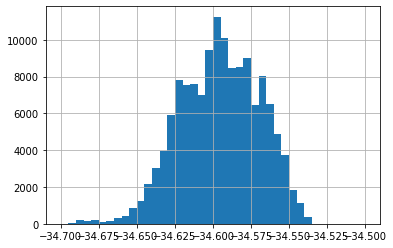

In [157]:
df_t['lat'].hist(bins = 40, range = (-34.7,-34.5));

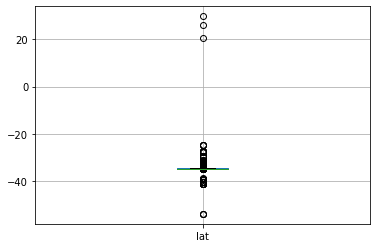

In [158]:
df_t.boxplot('lat');

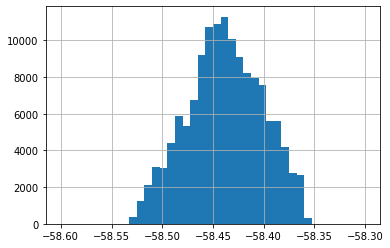

In [159]:
df_t['lon'].hist(bins = 40, range = (-58.6,-58.3));

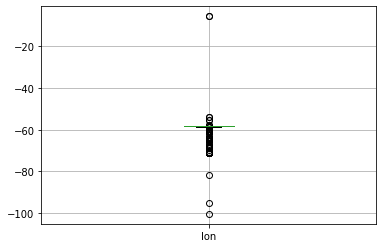

In [160]:
df_t.boxplot('lon')

In [161]:
df_t.l3.value_counts()

Palermo                22823
Belgrano               17975
Recoleta               13792
Caballito               9884
Villa Crespo            7247
Almagro                 7107
Villa Urquiza           7015
Balvanera               5903
Núñez                   4508
Flores                  4097
Colegiales              3269
San Cristóbal           3018
Puerto Madero           2791
Saavedra                2415
Villa Devoto            2354
San Telmo               2319
Villa del Parque        2112
Retiro                  2042
Boedo                   2006
San Nicolás             1907
Floresta                1793
Barracas                1657
Coghlan                 1456
Liniers                 1450
Monserrat               1412
Mataderos               1390
Parque Chacabuco        1374
Villa Luro              1357
Villa Pueyrredón        1345
Chacarita                967
Villa Lugano             838
Paternal                 824
Parque Patricios         807
Villa Ortúzar            785
Constitución  

In [162]:
df_p.l3.value_counts()

Palermo                206
Belgrano               110
Recoleta                97
Caballito               74
Villa Crespo            58
Almagro                 57
Barracas                39
Flores                  36
Núñez                   36
Villa Urquiza           34
Balvanera               34
Colegiales              27
San Telmo               24
Saavedra                23
Boedo                   20
Villa Devoto            17
Monserrat               17
San Nicolás             16
Puerto Madero           15
Floresta                14
Villa del Parque        12
Paternal                10
San Cristóbal           10
Villa Ortúzar            9
Parque Patricios         9
Constitución             8
Chacarita                6
Villa Luro               6
Monte Castro             6
Villa General Mitre      5
Nueva Pompeya            5
Parque Chacabuco         5
Retiro                   5
Parque Chas              5
Boca                     5
Villa Pueyrredón         5
Villa Santa Rita         3
L

Ver si reparar o recortar aquellos avisos sin información geográfica

In [163]:
(df_t.l3.isna() & (df_t.lon.isna() | df_t.lat.isna())).sum()

399

Comparar con https://www.coordenadas.com.es/argentina/pueblos-de-ciudad-buenos-aires/7/1

In [164]:
df_t[['l3','lon','lat']].groupby(by = 'l3').agg(['mean','median'],axis = 'columns')

lon                   lat           
                          mean     median       mean     median
l3                                                             
Agronomía           -58.488302 -58.489717 -34.594265 -34.593337
Almagro             -58.421919 -58.421587 -34.607042 -34.605265
Balvanera           -58.410650 -58.402251 -34.598778 -34.608618
Barracas            -58.374710 -58.373906 -34.637283 -34.636380
Belgrano            -58.452797 -58.453180 -34.563615 -34.563603
Boca                -58.363516 -58.363201 -34.633042 -34.632567
Boedo               -58.416899 -58.417547 -34.626213 -34.625888
Caballito           -58.442534 -58.442053 -34.618608 -34.619083
Chacarita           -58.450720 -58.450904 -34.586955 -34.586777
Coghlan             -58.475021 -58.475767 -34.560787 -34.559439
Colegiales          -58.451230 -58.451554 -34.577747 -34.577728
Constitución        -58.385250 -58.385683 -34.625194 -34.625303
Flores              -58.463242 -58.463144 -34.628355 -34.628517
Floresta            -58.486664 -58.484411 -34.629247 -34.629357
Liniers             -58.517364 -58.518725 -34.644544 -34.644444
Mataderos           -58.504293 -58.505983 -34.654922 -34.654786
Monserrat           -58.383619 -58.384181 -34.614223 -34.614331
Monte Castro        -58.504067 -58.504571 -34.620495 -34.620853
Nueva Pompeya       -58.419167 -58.419065 -34.647664 -34.646481
Núñez               -58.464387 -58.465179 -34.548566 -34.548631
Palermo             -58.424886 -58.424593 -34.582278 -34.581940
Parque Avellaneda   -58.479147 -58.478806 -34.644807 -34.644449
Parque Chacabuco    -58.437268 -58.438708 -34.635160 -34.634491
Parque Chas         -58.477915 -58.477475 -34.585738 -34.585481
Parque Patricios    -58.404206 -58.404431 -34.632549 -34.632502
Paternal            -58.464824 -58.465813 -34.602575 -34.602723
Puerto Madero       -58.362366 -58.361774 -34.613005 -34.612784
Recoleta            -58.398261 -58.398684 -34.592772 -34.592522
Retiro              -58.386563 -58.378571 -34.596627 -34.597220
Saavedra            -58.482532 -58.482086 -34.551802 -34.552440
San Cristóbal       -58.400358 -58.401417 -34.621951 -34.622734
San Nicolás         -58.386001 -58.384858 -34.602995 -34.602926
San Telmo           -58.392728 -58.374678 -34.589550 -34.621313
Versalles           -58.517375 -58.519927 -34.629359 -34.629692
Villa Crespo        -58.439961 -58.440873 -34.598562 -34.598387
Villa Devoto        -58.510882 -58.510772 -34.603032 -34.603409
Villa General Mitre -58.468303 -58.468752 -34.609777 -34.610317
Villa Lugano        -58.502592 -58.474210 -34.603060 -34.678826
Villa Luro          -58.502670 -58.503993 -34.638733 -34.638978
Villa Ortúzar       -58.468916 -58.469704 -34.581706 -34.582157
Villa Pueyrredón    -58.501474 -58.502011 -34.585060 -34.584991
Villa Real          -58.521988 -58.524608 -34.619872 -34.619928
Villa Riachuelo     -58.470694 -58.469994 -34.692043 -34.690952
Villa Santa Rita    -58.481046 -58.480655 -34.615497 -34.615215
Villa Soldati       -58.442402 -58.443213 -34.665607 -34.665544
Villa Urquiza       -58.469722 -58.485612 -34.574104 -34.573915
Villa del Parque    -58.488820 -58.489075 -34.605975 -34.604937
Vélez Sarsfield     -58.491737 -58.488670 -34.633926 -34.635840

In [165]:
df_p[['l3','lon','lat']].groupby(by = 'l3').agg(['mean','median'],axis = 'columns')

lon                   lat           
                          mean     median       mean     median
l3                                                             
Agronomía           -58.477311 -58.477311 -34.595685 -34.595685
Almagro             -58.422552 -58.423839 -34.606356 -34.605436
Balvanera           -58.403269 -58.403760 -34.608748 -34.609901
Barracas            -58.376779 -58.373926 -34.638456 -34.638005
Belgrano            -58.453780 -58.449234 -34.565641 -34.566227
Boca                -58.364682 -58.364215 -34.635268 -34.634496
Boedo               -58.374621 -58.416617 -34.799768 -34.630298
Caballito           -58.443762 -58.443964 -34.617910 -34.617666
Chacarita           -58.452690 -58.452244 -34.584246 -34.583683
Coghlan             -19.451746 -58.472259 -11.437240 -34.561139
Colegiales          -58.447237 -58.449604 -34.576857 -34.578178
Constitución        -58.390579 -58.384412 -34.621629 -34.626055
Flores              -58.466011 -58.465793 -34.626666 -34.625476
Floresta            -58.495851 -58.496580 -34.624250 -34.624677
Liniers             -58.521298 -58.521683 -34.643153 -34.643888
Mataderos           -58.506543 -58.506543 -34.656768 -34.656768
Monserrat           -58.394016 -58.379238 -34.606428 -34.613712
Monte Castro        -58.505389 -58.504471 -34.619397 -34.619334
Nueva Pompeya       -58.419789 -58.421422 -34.642900 -34.643810
Núñez               -58.462953 -58.461037 -34.548969 -34.551543
Palermo             -58.427219 -58.426896 -34.583859 -34.581699
Parque Avellaneda   -58.473139 -58.473139 -34.645239 -34.645239
Parque Chacabuco    -58.435877 -58.437559 -34.635994 -34.638675
Parque Chas         -58.478257 -58.477140 -34.584371 -34.584289
Parque Patricios    -58.399466 -58.400873 -34.634932 -34.635360
Paternal            -58.468654 -58.468305 -34.599428 -34.604604
Puerto Madero       -58.362244 -58.361777 -34.614930 -34.615319
Recoleta            -58.401837 -58.402494 -34.592752 -34.593563
Retiro              -58.381151 -58.381181 -34.596960 -34.597760
Saavedra            -53.391584 -58.479363 -31.534797 -34.550123
San Cristóbal       -58.397621 -58.396436 -34.621985 -34.621538
San Nicolás         -58.812935 -58.381097 -34.116262 -34.602176
San Telmo           -58.373900 -58.371394 -34.621801 -34.621835
Versalles           -58.526318 -58.527704 -34.625002 -34.623301
Villa Crespo        -58.440767 -58.440631 -34.600274 -34.600599
Villa Devoto        -58.507554 -58.506366 -34.598774 -34.599692
Villa General Mitre -58.470689 -58.470853 -34.608771 -34.608790
Villa Lugano        -58.473578 -58.474260 -34.678860 -34.675307
Villa Luro          -58.506447 -58.508017 -34.633519 -34.632314
Villa Ortúzar       -58.469981 -58.471406 -34.581950 -34.580484
Villa Pueyrredón    -58.502611 -58.502377 -34.589146 -34.587866
Villa Real          -58.524096 -58.524096 -34.614855 -34.614855
Villa Santa Rita    -58.483423 -58.480131 -34.615671 -34.615309
Villa Urquiza       -58.485591 -58.485868 -34.574397 -34.570809
Villa del Parque    -58.486945 -58.487944 -34.603896 -34.601577
Vélez Sarsfield     -58.496055 -58.496055 -34.628118 -34.628118

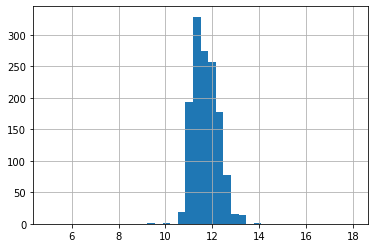

In [166]:
mask = (df_t.l3 == 'Villa Crespo') & (df_t.created_on.dt.month == 7) & (df_t.created_on.dt.year == 2020)
df_t.loc[mask,'price'].apply(np.log).hist(bins = 40, range = (5,18));

####Tipo de propiedad

In [167]:
df_t.property_type.value_counts()

Departamento    134044
PH               13581
Name: property_type, dtype: int64

In [168]:
((df_t.property_type == 'PH') & (df_t.l3 == 'Puerto Madero')).sum()

0

####Baños

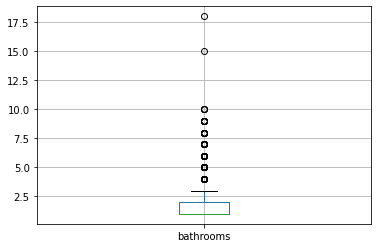

In [169]:
df_t.boxplot('bathrooms');

In [170]:
for i in range(3,7):
  print((df_t.bathrooms > i).sum())

4738
1390
238
80


In [171]:
(df_t.bathrooms == 0).sum()

0

####Ambientes

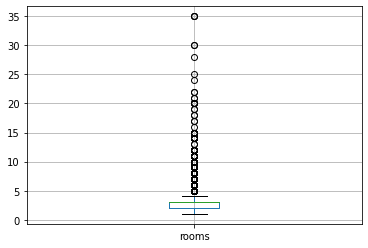

In [172]:
df_t.boxplot('rooms');

Filtrar más allá de 13, quizás entre 1 y 7/8/9

In [173]:
for i in range(4,10):  
  print((df_t.rooms > i).sum())

9573
3220
1417
639
333
182


In [174]:
(df_t.rooms == 0).sum()

0

####Dormitorios

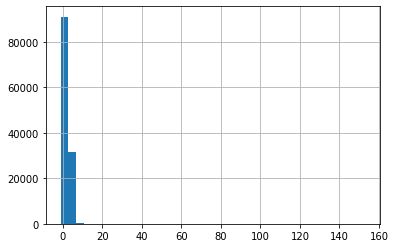

In [175]:
df_t.bedrooms.hist(bins = 40);

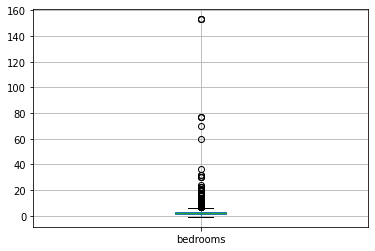

In [176]:
df_t.boxplot('bedrooms');

In [177]:
for i in range(4,11):
  print((df_t.bedrooms > i).sum())

1655
670
268
180
101
83
60


¿Son realmente cero dormitorios?

In [178]:
(df_t.bedrooms == 0).sum()

5091

####Fecha de finalización de aviso

In [179]:
df_t.end_date.value_counts()

9999-12-31    26158
2021-06-05    11998
2021-04-09     2713
2021-06-08     2707
2020-09-04     2441
              ...  
2020-05-31        6
2020-06-06        6
2020-06-21        3
2020-05-27        2
2020-05-26        2
Name: end_date, Length: 447, dtype: int64

####Superficie

Razonable que la superficie total esté entre 20m2/25m2 y 500m2/600m2

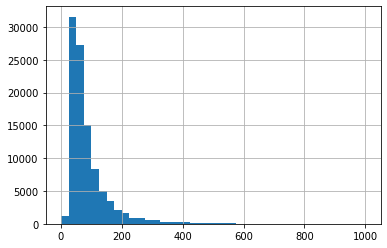

In [180]:
df_t.surface_total.hist(bins = 40,range = (0,1000));

In [181]:
for s in [300,400,500,600]:
  print((df_t.surface_total > s).sum())

2315
982
512
335


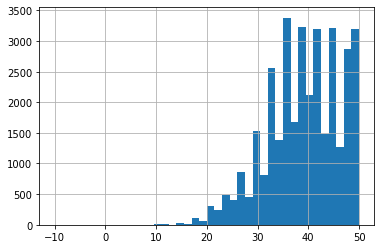

In [182]:
df_t.surface_total.hist(bins = 40,range = (-10,50));

In [183]:
for s in [20,25,30,35]:
  print((df_t.surface_total < s).sum())

231
1264
3428
9269


Para superficie cubierta:

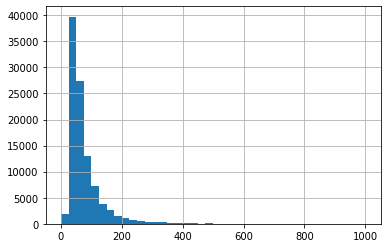

In [184]:
df_t.surface_covered.hist(bins = 40,range = (0,1000));

In [185]:
for s in [300,400,500,600]:
  print((df_t.surface_covered > s).sum())

1544
529
218
156


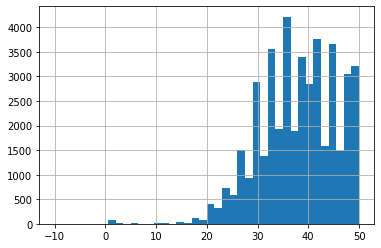

In [186]:
df_t.surface_covered.hist(bins = 40,range = (-10,50));

In [187]:
for s in [15,20,25,30,35]:
  print((df_t.surface_covered < s).sum())

148
385
1827
5777
14602


In [188]:
(df_t.surface_total-df_t.surface_covered).describe()

count    97718.000000
mean        21.740212
std        607.014140
min      -9769.000000
25%          0.000000
50%          5.000000
75%         10.000000
max      77420.000000
dtype: float64

####Precios

Un rango razonable sería entre 10000USD (jugar con https://www.properati.com.ar/s/capital-federal/departamento/venta?sort=price_asc y comparar con el conjunto a predecir) y 5000000USD

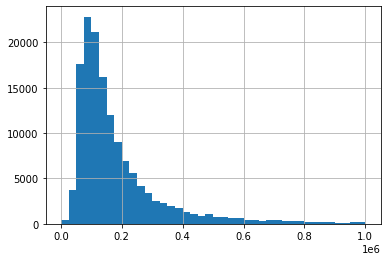

In [189]:
df_t.price.hist(bins = 40, range=(0,1000000));

Explorar precios bajos cuando se filtre la base de datos

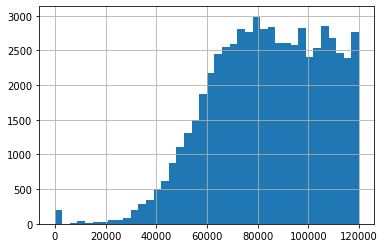

In [190]:
df_t.price.hist(bins = 40, range=(-100,120000));

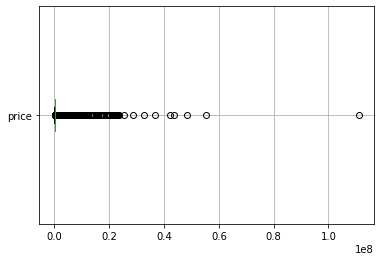

In [191]:
df_t.boxplot('price', vert = False);

Es una distribución de cola larga.

In [192]:
for i in [2500000,5000000,10000000,100000000]:
  print((df_t.price > i).sum())

475
127
84
1


No tengo idea de qué son esas propiedades de 1USD, investigar. Aunque en principio puedo filtrarlas.

In [193]:
for i in [1,5000,7500,10000]:
  print((df_t.price < i).sum())

195
197
201
232


####Título de aviso

Algo de información útil para dummies.

In [194]:
df_t_title = df_t['title'].astype(str).str.lower()

In [195]:
regexp = RegexpTokenizer('\w+')
df_t_title = df_t_title.apply(regexp.tokenize)

In [196]:
stopwords = nltk.corpus.stopwords.words("spanish")
stopwords.extend(['es', 'osea', 'sólo','br'])

df_t_title = df_t_title.apply(lambda texto: [token for token in texto if token not in stopwords])

In [197]:
df_t_title = df_t_title.str.join(' ')

In [198]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), strip_accents='ascii', max_features=2000, lowercase = False)
vectorized_data = vectorizer.fit_transform(df_t_title)

In [199]:
count_df_t_t = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out(), index = df_t.index)

In [200]:
count_df_t_t.sum().sort_values(ascending = False).head(50)

departamento    75819
venta           73460
ambientes       43911
amb             20958
capital         20273
federal         20261
villa           14919
palermo         14721
balcon          13904
belgrano        12789
cochera         12773
ph              12235
000             10541
monoambiente     9111
excelente        7724
terraza          7008
caballito        6783
estrenar         6582
recoleta         6303
piso             6022
patio            6003
depto            5998
amenities        5476
luminoso         5459
crespo           5337
almagro          5269
frente           5260
av               5153
san              4927
oportunidad      4728
apto             4724
urquiza          4476
ambiente         4263
ubicado          3838
parque           3762
m2               3591
norte            3491
barrio           3252
vista            3241
semipiso         3200
nunez            3108
torre            3079
dependencia      2938
duplex           2874
hermoso          2840
parrilla  

In [201]:
count_df_t_t.sum().sort_values(ascending = False).to_csv('keywords_train_title.csv')

####Descripción

Algo de información útil para dummies (por ejemplo, encontré gas y luz)

In [202]:
df_t_description = df_t['description'].str.lower()

In [203]:
regexp = RegexpTokenizer('\w+')
df_t_description = df_t_description.apply(regexp.tokenize)

In [204]:
stopwords = nltk.corpus.stopwords.words("spanish")
stopwords.extend(['es', 'osea', 'sólo','br'])

df_t_description = df_t_description.apply(lambda texto: [token for token in texto if token not in stopwords])
#df_pred["description"]

In [205]:
df_t_description = df_t_description.str.join(' ')

In [206]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), min_df=0.005, max_df=0.7, strip_accents='ascii', max_features=2000, lowercase = False)
vectorized_data = vectorizer.fit_transform(df_t_description)

In [207]:
count_df_t_d = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out(), index = df_t.index)

In [208]:
count_df_t_d.sum().sort_values(ascending = False).head(50)

ambientes       142282
bano            127472
balcon          127388
piso            120086
comedor         119847
departamento    114703
living          111763
edificio        105209
expensas        100101
pisos            91336
medidas          88589
completo         87117
frente           86269
av               84080
excelente        81693
dormitorio       81371
propiedad        72902
amplio           65728
dos              65001
venta            63244
dormitorios      63015
placard          62610
m2               60221
lavadero         59808
inmueble         57482
luminoso         57258
cuadras          51590
cuenta           51399
cochera          51148
aire             50671
terraza          50475
valor            48628
aviso            46456
vista            46068
gran             44331
servicio         43863
unidades         43456
ubicado          43238
ubicacion        43051
superficies      42586
titulo           41535
suite            40072
toilette         38972
salida     

In [209]:
count_df_t_d.sum().sort_values(ascending = False).to_csv('keywords_train_description.csv')

####Tipo de propiedad y barrio

PHs no están concentrados en pocos barrios.

In [210]:
df_t.loc[df_t.property_type == 'PH','l3'].value_counts()

Palermo                912
Villa Urquiza          846
Caballito              690
Almagro                647
Mataderos              606
Villa Crespo           599
Villa Devoto           590
Saavedra               466
Balvanera              442
Flores                 437
Villa Pueyrredón       410
Floresta               405
Boedo                  392
Belgrano               384
Villa del Parque       364
Liniers                345
Colegiales             336
Parque Chacabuco       315
San Cristóbal          310
Villa Luro             301
Núñez                  267
Parque Patricios       235
Recoleta               227
Barracas               226
Paternal               214
San Telmo              213
Villa Lugano           201
Chacarita              191
Monte Castro           181
Parque Avellaneda      173
Coghlan                152
Villa Ortúzar          151
Villa Santa Rita       145
Monserrat              135
Villa General Mitre    130
Vélez Sarsfield        124
Versalles              121
N

##Segundo filtrado de la base de datos

Remuevo aquellas propiedades sin precio para entrenar (aunque quizás esté en el aviso)

In [211]:
df_t = df_t[df_t.price.notna()]

Elimino entradas con coordenadas incorrectas (aunque más adelante voy a intentar arreglarlas fijándome las coordenadas de cada parte de la ciudad).

In [212]:
df_t = df_t.loc[(df_t.lon > -58.6) & (df_t.lon < -58.3) & (df_t.lat > -34.7) & (df_t.lat < -34.5)]
df_t.shape

(136643, 19)

Hago los rangos de properati comparables con los del conjunto a predecir.

In [213]:
df_t = df_t.loc[(df_t.surface_total >= 15) & (df_t.surface_total <=600)]
df_t.shape

(92157, 19)

In [214]:
df_t = df_t.loc[(df_t.surface_covered >= 15) & (df_t.surface_covered <= 600)]
df_t.shape

(89530, 19)

In [215]:
df_t = df_t.loc[df_t.rooms < 14]
df_t.shape

(87134, 19)

In [216]:
df_t = df_t.loc[(df_t.bedrooms < 13) & (df_t.bedrooms > 0)]
df_t.shape

(73053, 19)

In [217]:
df_t = df_t.loc[df_t.bathrooms < 8]
df_t.shape

(72792, 19)

Probar con filtros de precio más o menos restrictivos

In [218]:
df_t = df_t.loc[(df_t.price >= 10000) & (df_t.price < 5000000)]
df_t.shape

(72642, 19)

Elimino las entradas que no son en USD (aunque luego quiero convertir monedas si me alcanza el tiempo)

In [219]:
df_t = df_t.loc[df_t.currency == 'USD']
df_t.shape

(72623, 19)

##Imputación/transformación

In [220]:
def glue(dftrain,dftest):
  df = pd.concat([dftrain,dftest], axis = 0)
  return df

def unglue(df,col):
  dftrain = df.loc[df[col].notna()]
  dftest = df.loc[df[col].isna()]
  return dftrain, dftest

In [221]:
df = glue(df_t,df_p)

###Llenar coordenadas

Se las llena en base a l3 y el valor de la coordenada mediana de cada barrio

In [222]:
coords = df_t[['l3','lon','lat']].groupby(by = 'l3').agg(['median'],axis = 'columns').to_dict()#quizás quiero construir este diccionario en otra parte para tener más coordenadas
lat_dict = coords[('lat','median')]
lon_dict = coords[('lon','median')]
#puede añadirse los barrios que faltan si es necesario

In [223]:
def fill_coords(row,lat_dict,lon_dict):
  if((math.isnan(row['lat']) or math.isnan(row['lon'])) and not pd.isna(row['l3'])):
    row['lat'] = lat_dict[row['l3']]
    row['lon'] = lon_dict[row['l3']]
  return row

In [224]:
df = df.apply(lambda x: fill_coords(x,lat_dict,lon_dict), axis = 'columns')

###Imputar superficies

Donde falte una superficie la lleno con el valor de la otra

In [225]:
def fill_surf(row):
  if(pd.isna(row['surface_total']) and pd.notna(row['surface_covered'])):
    row['surface_total'] = row['surface_covered']
  elif(pd.notna(row['surface_total']) and pd.isna(row['surface_covered'])):
    row['surface_covered'] = row['surface_total']
  return row

In [226]:
df = df.apply(fill_surf, axis = 'columns')

###Imputar por KNN

In [227]:
col = ['lat','lon','bathrooms','bedrooms','rooms','surface_total','surface_covered']
s = StandardScaler()

df[col] = s.fit_transform(df[col])

In [228]:
maskdict = {}
for ptype in df.property_type.unique():
  maskdict[ptype] = (df.property_type == ptype)

In [229]:
imp = KNNImputer(n_neighbors=2, weights="uniform")
#col = ['lat','lon','bathrooms','bedrooms','rooms','surface_total','surface_covered']
for ptype, mask in maskdict.items():
  df.loc[mask,col] =imp.fit_transform(df.loc[mask,col])

In [230]:
df[col] = s.inverse_transform(df[col])

In [231]:
to_round_list = ['bathrooms','bedrooms','rooms','surface_total','surface_covered']
df[to_round_list] = df[to_round_list].round(0) 

##Nuevas variables

####En base a superficie

In [232]:
df['logsurface_covered'] = np.log(df.surface_covered + 0.1)

In [233]:
df['logsurface_total'] = np.log(df.surface_total + 0.1)

####En base a barrio y tipo de propiedad

Lugares caros de capital

In [234]:
df['Puerto_Madero'] = (df.l3 == 'Puerto Madero')

In [235]:
df['Palermo'] = (df.l3 == 'Palermo')

In [236]:
df['Núñez'] = (df.l3 == 'Núñez')

In [237]:
df['Belgrano'] = (df.l3 == 'Belgrano')

In [238]:
df['Recoleta'] = (df.l3 == 'Recoleta')

Lugares baratos de capital

In [239]:
df['Nueva_Pompeya'] = (df.l3 == 'Nueva_Pompeya')

In [240]:
df['Versalles'] = (df.l3 == 'Versalles')

In [241]:
df['Constitución'] = (df.l3 == 'Constitución')

In [242]:
df['Boca'] = (df.l3 == 'Boca')

In [243]:
df['Villa_Lugano'] = (df.l3 == 'Villa Lugano')

In [244]:
df['PH'] = (df.property_type == 'PH')

####En base a USD/m2

In [245]:
df_usdpersqm.loc[:,2022,4].mean()

Precio m² (USD)    2281.192906
dtype: float64

In [246]:
def USDperm2(row,df_usdpersqm,month,year):
  if (pd.notna(row.l3)):
    row['USDperm2'] = float(df_usdpersqm.loc[row.l3,year,month])
  else:
    row['USDperm2'] = 2281.192906#promedio de abril de 2022
  return row

In [247]:
df['USDperm2'] = np.nan
df = df.apply(lambda x: USDperm2(x,df_usdpersqm,4,2022), axis = 'columns')

In [248]:
df['average_price'] = df.USDperm2 * df.surface_total

####Puede que aumenten el valor de la propiedad...

Sí, expresiones regulares era una mejor idea, pero las aprendí después de escribir esto.

Dataframes necesarios: count_df_pred_d, count_df_pred_de (cocheras, quizás duplex/varios pisos), count_df_pred_a, count_df_pred_s (gas, luz), count_df_t_t y count_df_t_d.

In [249]:
#print(count_df_t_t.loc[df[df.price.notna()].index].cochera)
df.loc[df.price.isna(),'parking'] = ((count_df_pred_d.cochera + count_df_pred_d.cocheras + count_df_pred_de.cocheras) > 0)
mask = df[df.price.notna()].index
df.loc[df.price.notna(),'parking'] = ((count_df_t_t.loc[mask,'cochera'] + count_df_t_t.cocheras + count_df_t_t.loc[mask,'2cocheras'] + count_df_t_d.loc[mask,'cochera'] + count_df_t_d.loc[mask,'cocheras']) > 0)
df.parking = df.parking.astype('bool') 

In [250]:
df.loc[df.price.isna(),'balcony'] = ((count_df_pred_d.balcon + count_df_pred_d.balcones + count_df_pred_a.balcon) > 0)
mask = df[df.price.notna()].index
df.loc[df.price.notna(),'balcony'] = ((count_df_t_t.loc[mask,'balcon'] + count_df_t_t.loc[mask,'balcones'] + count_df_t_d.loc[mask,'balcon'] + count_df_t_d.loc[mask,'balcones']) > 0)
df.balcony = df.balcony.astype('bool')

In [251]:
df.loc[df.price.isna(),'duplex'] = ((count_df_pred_d.duplex + count_df_pred_d.entrepiso) > 0)
mask = df[df.price.notna()].index
df.loc[df.price.notna(),'duplex'] = ((count_df_t_t.loc[mask,'duplex'] + count_df_t_t.loc[mask,'entrepiso'] + count_df_t_d.loc[mask,'entrepiso'] + count_df_t_d.loc[mask,'duplex']) > 0)
df.duplex = df.duplex.astype('bool')

In [252]:
df.loc[df.price.isna(),'terrace'] = ((count_df_pred_d.terraza + count_df_pred_d.terrazas + count_df_pred_d.aterrazado + count_df_pred_a.terraza) > 0)
mask = df[df.price.notna()].index
df.loc[df.price.notna(),'terrace'] = ((count_df_t_t.loc[mask,'terraza'] + count_df_t_t.loc[mask,'terrazas'] + count_df_t_t.loc[mask,'aterrazado'] + count_df_t_d.loc[mask,'terraza'] + count_df_t_d.loc[mask,'terrazas'] + count_df_t_d.loc[mask,'aterrazado']) > 0)
df.terrace = df.terrace.astype('bool')

In [253]:
df['many_rooms'] = (df.rooms > 6)

###En base a superficie y número de ambientes

In [254]:
df['surfdivrooms'] = df.surface_covered / (df.rooms + 0.001)

###Exploración nuevas variables

In [255]:
df.columns

Index(['start_date', 'end_date', 'created_on', 'lat', 'lon', 'l3', 'l4',
       'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'price', 'currency', 'price_period', 'title', 'description',
       'property_type', 'operation_type', 'details', 'additionals', 'services',
       'logsurface_covered', 'logsurface_total', 'Puerto_Madero', 'Palermo',
       'Núñez', 'Belgrano', 'Recoleta', 'Nueva_Pompeya', 'Versalles',
       'Constitución', 'Boca', 'Villa_Lugano', 'PH', 'USDperm2',
       'average_price', 'parking', 'balcony', 'duplex', 'terrace',
       'many_rooms', 'surfdivrooms'],
      dtype='object')

####Correlaciones

Se eliminaron los outliers de superficie, parece.

In [256]:
df[['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered','price']].corr()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
lat,1.000000,0.987140,0.001312,0.001111,0.012976,0.007070,0.009337,0.185368
lon,0.987140,1.000000,0.006527,0.005911,0.010924,0.009333,0.013682,0.205365
rooms,0.001312,0.006527,1.000000,0.907014,0.628031,0.750284,0.763420,0.503873
bedrooms,0.001111,0.005911,0.907014,1.000000,0.646310,0.710386,0.720122,0.472517
bathrooms,0.012976,0.010924,0.628031,0.646310,1.000000,0.710816,0.734495,0.653607
surface_total,0.007070,0.009333,0.750284,0.710386,0.710816,1.000000,0.945291,0.767456
surface_covered,0.009337,0.013682,0.763420,0.720122,0.734495,0.945291,1.000000,0.811056
price,0.185368,0.205365,0.503873,0.472517,0.653607,0.767456,0.811056,1.000000


####Exploración precio promedio en base a superficie

Para el conjunto a predecir:

In [257]:
df[df.price.isna()].average_price.describe()

count    1.087000e+03
mean     2.484522e+05
std      2.380643e+05
min      3.074369e+04
25%      1.143671e+05
50%      1.671875e+05
75%      2.832073e+05
max      1.856783e+06
Name: average_price, dtype: float64

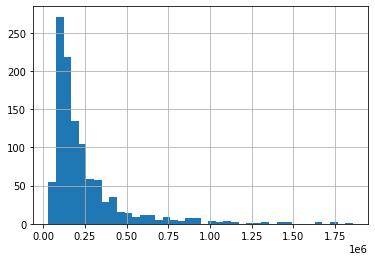

In [258]:
df[df.price.isna()].average_price.hist(bins = 40);

Para el conjunto de entrenamiento: 

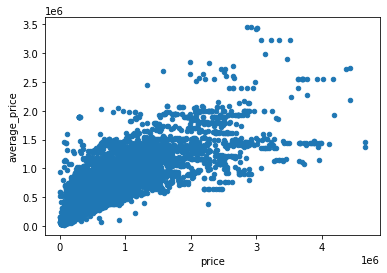

In [259]:
df[df.price.notna()].plot.scatter(x = 'price', y = 'average_price');

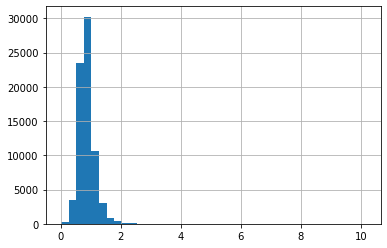

In [260]:
(df[df.price.notna()].price / df[df.price.notna()].average_price).hist(bins = 40);

Hay una relación fuerte entre el precio promedio y el precio real. Para seleccionar los límites de precio basta con tomar el precio promedio máximo para el conjunto a predecir y multiplicarlo por un margen de seguridad (2 a 5?). Con 5000000USD debería estar bien, quizás un poco más.

In [261]:
df[df.price.notna()].price.corr(df[df.price.notna()].average_price)

0.8709351715905964

In [262]:
mean_squared_error(df[df.price.notna()].price, df[df.price.notna()].average_price, squared = False)

155422.2369364478

####Buscando valores atípicos de superficie cubierta dividido número de ambientes

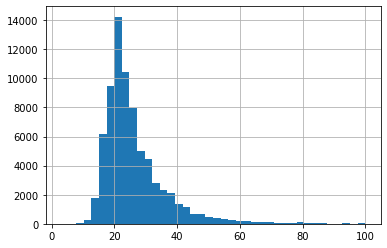

In [263]:
df.surfdivrooms.hist(range = (3,100), bins = 40);

In [264]:
for i in [80,100,150,200,250,500]:
  print((df.loc[df.price.notna(),'surfdivrooms'] > i).sum())

253
50
17
12
9
0


In [265]:
for i in [80,100,150,200,250,500]:
  print((df.loc[df.price.isna(),'surfdivrooms'] > i).sum())

11
4
2
1
1
1


####Derivados de superficie

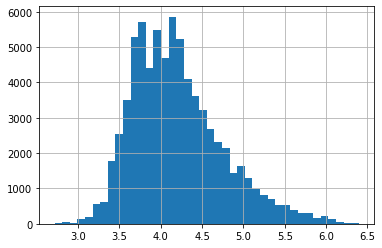

In [266]:
df.logsurface_covered.hist(bins = 40);

##Separo conjunto de entrenamiento y a predecir, filtro de columnas

In [267]:
df_t, df_p = unglue(df,'price')#llamar a esta función resetea las columnas dado que no se haya tocado df.

In [268]:
base = ['lat', 'lon', 'rooms', 'bathrooms', 'surface_total', 'surface_covered'] + ['bedrooms'] #,'price'
baselog = ['lat', 'lon', 'rooms', 'bathrooms', 'logsurface_total', 'logsurface_covered'] + ['bedrooms']
balcony = ['balcony']
parking = ['parking']
terrace = ['terrace']
USDpersqm = ['USDperm2']
p_type = ['PH']
l3_expensive = ['Puerto_Madero','Palermo','Núñez','Belgrano','Recoleta']
l3_cheap = ['Nueva_Pompeya', 'Versalles', 'Constitución', 'Boca','Villa_Lugano']
many_rooms = ['many_rooms']
duplex = ['duplex']
surfdivrooms = ['surfdivrooms']
col = base + USDpersqm + ['Puerto_Madero'] + parking + p_type 
#base + USDpersqm + ['Puerto_Madero'] + parking + p_type

##Tercer filtro en base a nuevas variables

In [269]:
filterbysurfdivrooms = False

In [270]:
if (filterbysurfdivrooms):
  df_t = df_t[df_t.surfdivrooms < 150]

##Selección de subconjunto de datos

Esta parte es por si se decide utilizar varios modelos, se puede crear modelos y hacer predicciones solo para datos que cumplan ciertas condiciones (en otro lado se prueba combinarlos).

In [271]:
filter_Puerto_Madero = False
filter_not_Puerto_Madero = False

In [272]:
filter_PH = False
filter_not_PH = False

In [273]:
filter_mid = False
filter_expensive = False
filter_cheap = False

In [274]:
filter_big = False
filter_not_big = False

In [275]:
filter_small = False
filter_not_small = False

In [276]:
filter_mid_size = False

In [277]:
if (filter_Puerto_Madero):
  df_t = df_t[df_t.Puerto_Madero == 1]
  df_p = df_p[df_p.Puerto_Madero == 1]
if (filter_not_Puerto_Madero):
  df_t = df_t[df_t.Puerto_Madero == 0]
  df_p = df_p[df_p.Puerto_Madero == 0]

In [278]:
if (filter_PH):
  df_t = df_t[df_t.PH == 1]
  df_p = df_p[df_p.PH == 1]
if (filter_not_PH):
  df_t = df_t[df_t.PH == 0]
  df_p = df_p[df_p.PH == 0]

In [279]:
if(filter_mid):
  mask = ((df_t.Puerto_Madero == 1) | (df_t.Palermo == 1) | (df_t.Núñez == 1) | (df_t.Belgrano == 1) | (df_t.Recoleta == 1))
  mask = mask | ((df_t.Nueva_Pompeya == 1) | (df_t.Versalles == 1) | (df_t.Constitución == 1) | (df_t.Boca == 1) | (df_t.Villa_Lugano == 1))
  df_t = df_t[~mask]
  mask = ((df_p.Puerto_Madero == 1) | (df_p.Palermo == 1) | (df_p.Núñez == 1) | (df_p.Belgrano == 1) | (df_p.Recoleta == 1))
  mask = mask | ((df_p.Nueva_Pompeya == 1) | (df_p.Versalles == 1) | (df_p.Constitución == 1) | (df_p.Boca == 1) | (df_p.Villa_Lugano == 1))
  df_p = df_p[~mask]
if(filter_expensive):
  mask = ((df_t.Puerto_Madero == 1) | (df_t.Palermo == 1) | (df_t.Núñez == 1) | (df_t.Belgrano == 1) | (df_t.Recoleta == 1))
  df_t = df_t[mask]
  mask = ((df_p.Puerto_Madero == 1) | (df_p.Palermo == 1) | (df_p.Núñez == 1) | (df_p.Belgrano == 1) | (df_p.Recoleta == 1))
  df_p = df_p[mask]
if(filter_cheap):
  mask = ((df_t.Nueva_Pompeya == 1) | (df_t.Versalles == 1) | (df_t.Constitución == 1) | (df_t.Boca == 1) | (df_t.Villa_Lugano == 1))
  df_t = df_t[mask]
  mask = ((df_p.Nueva_Pompeya == 1) | (df_p.Versalles == 1) | (df_p.Constitución == 1) | (df_p.Boca == 1) | (df_p.Villa_Lugano == 1))
  df_p = df_p[mask]

In [280]:
if(filter_big):
  mask = (df_t.surface_covered > 250)
  df_t = df_t[mask]
  mask = (df_p.surface_covered > 250)
  df_p = df_p[mask]
if(filter_not_big):
  mask = (df_t.surface_covered < 250)
  df_t = df_t[mask]
  mask = (df_p.surface_covered < 250)
  df_p = df_p[mask]

In [281]:
if(filter_small):
  mask = (df_t.surface_covered < 50)
  df_t = df_t[mask]
  mask = (df_p.surface_covered < 50)
  df_p = df_p[mask]
if(filter_not_small):
  mask = (df_t.surface_covered > 50)
  df_t = df_t[mask]
  mask = (df_p.surface_covered > 50)
  df_p = df_p[mask]

In [282]:
if(filter_mid_size):
  mask = ((df_t.surface_covered < 200) & (df_t.surface_covered > 50))
  df_t = df_t[mask]
  mask = ((df_p.surface_covered < 200) & (df_p.surface_covered > 50))
  df_p = df_p[mask]

# Modelización

##Entrenamiento

Puedo convertir precios a logaritmo (aunque no me funcionó demasiado bien, quizás porque no terminé de limpiar bien los datos)

In [283]:
use_log = False

In [284]:
X = df_t[col]
#X = X.select_dtypes(include=['float64', 'int64', 'bool'])
#df.fillna(0, inplace=True, downcast= "infer")

In [285]:
#X = X[X.columns.drop(['price'])]
y = df_t['price']

if(use_log):
  y = np.log(y + 1)

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.20, random_state = None)#, stratify=df_train.loc[df.index, 'property_type'])

n_estimators = 100
max_depth = 11

#for n_estimators in [100, 500, 1000]:     
#    for max_depth in [3, 7, 11]:

        ## Tienen que usar RandomForestRegressor si o si o si. Pueden cambiar los parámetros
#        reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)

        ## Validación cruzada en 5 partes (lo van a ver en AA), -RMSE. No tocar
#        scores = sk.model_selection.cross_val_score(reg, X, y, cv=10, scoring='neg_root_mean_squared_error')

        ## Imprimimos scores. Cuando más bajo mejor
#        print(f"n_estimators={n_estimators}, max_depth={max_depth} --> {-scores.mean():.3f} +/- {scores.std():.3f}")

reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)

scores = sk.model_selection.cross_val_score(reg, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')

print(scores.mean(), scores.std())

-89172.63758844636 2822.4739965374906


In [286]:
reg.fit(X_train,y_train)
y_holdout_pred = reg.predict(X_holdout)

if(use_log):
  y_holdout = np.exp(y_holdout)
  y_holdout_pred = np.exp(y_holdout_pred)
print(-1 * mean_squared_error(y_holdout,y_holdout_pred, squared = False))

-87485.71161057208


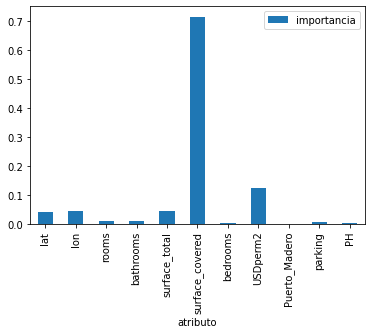

In [287]:
pd.DataFrame({'atributo': reg.feature_names_in_, 'importancia': reg.feature_importances_}).plot.bar(x="atributo", y="importancia");

##Diagnóstico

In [288]:
s_holdout_pred = pd.Series(y_holdout_pred, index = y_holdout.index)

In [289]:
mask = (df_t.loc[X_holdout.index,'Puerto_Madero'] == 1)
print(-1 * mean_squared_error(y_holdout[mask],y_holdout_pred[mask], squared = False))

-222902.30951681975


In [290]:
mask = ((df_t.loc[X_holdout.index,'Palermo'] == 1) | (df_t.loc[X_holdout.index,'Núñez'] == 1) | (df_t.loc[X_holdout.index,'Belgrano'] == 1) | (df_t.loc[X_holdout.index,'Recoleta'] == 1))
print(-1 * mean_squared_error(y_holdout[mask],y_holdout_pred[mask], squared = False))

-119286.57800521787


In [291]:
mask = (df_t.loc[X_holdout.index,'Villa_Lugano'] == 1)
print(-1 * mean_squared_error(y_holdout[mask],y_holdout_pred[mask], squared = False))

-16047.667856281985


In [292]:
mask = ((df_t.loc[X_holdout.index,'Nueva_Pompeya'] == 1) | (df_t.loc[X_holdout.index,'Versalles'] == 1) | (df_t.loc[X_holdout.index,'Constitución'] == 1) | (df_t.loc[X_holdout.index,'Boca'] == 1))
print(-1 * mean_squared_error(y_holdout[mask],y_holdout_pred[mask], squared = False))

-25623.18093575225


In [293]:
mask = (df_t.loc[X_holdout.index,'Puerto_Madero'] == 1)
mask = mask | ((df_t.loc[X_holdout.index,'Palermo'] == 1) | (df_t.loc[X_holdout.index,'Núñez'] == 1) | (df_t.loc[X_holdout.index,'Belgrano'] == 1) | (df_t.loc[X_holdout.index,'Recoleta'] == 1))
mask = mask | ((df_t.loc[X_holdout.index,'Nueva_Pompeya'] == 1) | (df_t.loc[X_holdout.index,'Versalles'] == 1) | (df_t.loc[X_holdout.index,'Constitución'] == 1) | (df_t.loc[X_holdout.index,'Boca'] == 1))
mask = mask | (df_t.loc[X_holdout.index,'Villa_Lugano'] == 1)
mask = ~mask
print(-1 * mean_squared_error(y_holdout[mask],y_holdout_pred[mask], squared = False))

-37504.52000333614


In [294]:
mask = (df_t.loc[X_holdout.index,'PH'] == 1)
print(-1 * mean_squared_error(y_holdout[mask],y_holdout_pred[mask], squared = False))

-56660.06279806287


In [295]:
mask = (df_t.loc[X_holdout.index,'PH'] == 0)
print(-1 * mean_squared_error(y_holdout[mask],y_holdout_pred[mask], squared = False))

-90460.07946631123


In [296]:
mask = (X_holdout.surface_covered > 300)
print(-1 * mean_squared_error(y_holdout[mask],y_holdout_pred[mask], squared = False))

-378796.9078892039


In [297]:
mask = ((X_holdout.surface_covered < 300) & (X_holdout.surface_covered > 200))
print(-1 * mean_squared_error(y_holdout[mask],y_holdout_pred[mask], squared = False))

-285471.740943558


In [298]:
mask = ((X_holdout.surface_covered < 200) & (X_holdout.surface_covered > 100))
print(-1 * mean_squared_error(y_holdout[mask],y_holdout_pred[mask], squared = False))

-101681.26141162017


In [299]:
mask = ((X_holdout.surface_covered < 150) & (X_holdout.surface_covered > 100))
print(-1 * mean_squared_error(y_holdout[mask],y_holdout_pred[mask], squared = False))

-85377.46464439544


In [300]:
mask = ((X_holdout.surface_covered < 100) & (X_holdout.surface_covered > 50))
print(-1 * mean_squared_error(y_holdout[mask],y_holdout_pred[mask], squared = False))

-40990.70976200467


In [301]:
mask = (X_holdout.surface_covered < 50)
print(-1 * mean_squared_error(y_holdout[mask],y_holdout_pred[mask], squared = False))

-22038.727174259147


##Predicción

In [302]:
#df_p = pd.read_csv('/content/a_predecir.csv', index_col="id")
#df_p.fillna(0, inplace=True)

In [303]:
X_pred = df_p[X.columns]

In [304]:
# los mejores hiperparámetros encontrados antes
#n_estimators = 100
#max_depth = 7

# entrenamiento
reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)
reg.fit(X, y)

# predicción
y_pred = reg.predict(X_pred)

if(use_log):
  y_pred = np.exp(y_pred)

df_p["price"] = y_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


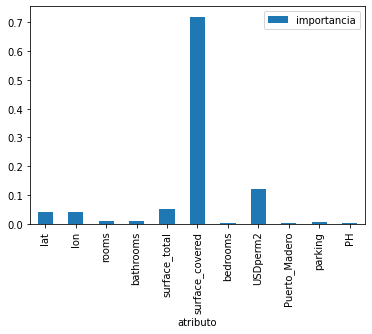

In [305]:
pd.DataFrame({'atributo': reg.feature_names_in_, 'importancia': reg.feature_importances_}).plot.bar(x="atributo", y="importancia");

In [306]:
# grabo la solución
df_p[["price"]].to_csv("solucion.csv")